# simple synthetic inversion

Here we try to recover the true Layer 1 topography with a gravity inversion. We start with the forward gravity of Layer 1 as the observed gravity, then down-sample this gravity to represent a coarser gravity survey, and final, repeate these steps with a regional component including in the observed gravity. The regional component is the forward gravity of Layer 2. 

We also explore adding gaussian noise to these gravity data. 

The starting (low-resolution) Layer 1 topography has been created through the random sampling and gridding of 30 points. In an Antarctic setting, these points represent single seismic survey locations which measure the elevation of Layer 1. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [2]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

starting_layer1 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer1.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
starting_layer1 = starting_layer1.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(starting_layer1))
starting_layer1

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -952.152099609, -481.448486328, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -4689.66455078, -3614.13256836, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -941.945495605, -430.007873535, 'g')


<xarray.DataArray 'z' (northing: 73, easting: 93)>
dask.array<open_dataset-5f77f54453cc56c3605ecef2a0f1885az, shape=(73, 93), dtype=float64, chunksize=(73, 93), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.4e+04 8.5e+04 8.6e+04
  * northing  (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
Attributes:
    metadata:  Generated by Spline()

## gravity data
* full resolution forward gravity of Layer 1
* full resolution with regional component
* sampled forward gravity of Layer 1
* sampled with regional component

In [3]:
# full resolution gravity point data
grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
# sampled gravity point data
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_regional_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [4]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 1e3
sampled_grav_spacing = 2e3

inversion_region = utils.alter_region(
    buffer_region,
    zoom=6e3,
)[0]

# set density contrast
density = 2300 - 1024

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-6000.0, 86000.0, -6000.0, 66000.0]


# Prep data

## grav data

In [5]:
# full_res_grav = inv_utils.prep_grav_data(
#     grav,
#     region=inversion_region,
#     input_grav_name="Surface1",
#     input_coord_names=("easting", "northing", "upward"),
# )
# full_res_grav_with_reg = inv_utils.prep_grav_data(
#     grav,
#     region=inversion_region,
#     input_grav_name="forward_total",
#     input_coord_names=("easting", "northing", "upward"),
# )
# sampled_grav = inv_utils.prep_grav_data(
#     sampled_grav,
#     region=inversion_region,
#     input_grav_name="Gobs",
#     input_coord_names=("easting", "northing", "upward"),
# )
# sampled_grav_with_reg = inv_utils.prep_grav_data(
#     sampled_grav_with_reg,
#     region=inversion_region,
#     input_grav_name="Gobs",
#     input_coord_names=("easting", "northing", "upward"),
# )

# print(f"full resolution gravity: {len(full_res_grav)} points")
# print(f"sampled gravity: {len(sampled_grav)} points")

# print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

## constraint points

In [6]:
# load constraint points into a dataframe
constraints_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraints = utils.points_inside_region(
    constraints_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")
constraints.head()

bathymetry control points:30


easting      northing      upward
0  33361.760376   5900.810030 -728.101857
1  57625.959475  25266.457500 -703.361847
2      9.149985  57473.371809 -533.972411
3  24186.605811  31989.917098 -715.684441
4  11740.471265  41512.626837 -703.378641

## plot inputs

In [7]:
# # grid the observed gravity
# Gobs = full_res_grav_with_reg.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 2
# fig = maps.plot_grd(
#     grid=layer2,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Layer 2",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

In [8]:
# # grid the observed gravity
# Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the starting Layer 1 density contrast. This will be the input into our inversion.


## layer 1 prisms

In [9]:
# create prisms around starting layer 1
# positive densities above reference, negative below
print(f"Layer 1 density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer1,
    reference=starting_layer1.values.mean(),
    density=xr.where(
        starting_layer1 >= starting_layer1.values.mean(), density, -density
    ),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Layer 1 density contrast: 1276kgm-3


## layer 1 gravity

In [10]:
# # calculate gravity of layer1
# layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [layer1_prisms],
#     full_res_grav,
#     names=["layer1_prisms"],
#     remove_median=False,
#     progressbar=True,
#     plot=False,
# )

# full_res_grav["layer1_forward"] = layer1_grav_df.forward_total
# full_res_grav_with_reg["layer1_forward"] = layer1_grav_df.forward_total

# full_res_grav

In [11]:
# # repeat with sampled gravity
# layer1_sampled_grav_grid, layer1_sampled_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [layer1_prisms],
#     sampled_grav,
#     names=["layer1_prisms"],
#     remove_median=False,
#     progressbar=True,
#     plot=False,
# )

# sampled_grav["layer1_forward"] = layer1_sampled_grav_df.forward_total
# sampled_grav_with_reg["layer1_forward"] = layer1_sampled_grav_df.forward_total

# sampled_grav

## Misfit

In [12]:
# full_res_grav = inv.misfit(
#     input_grav=full_res_grav,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )
# full_res_grav_with_reg = inv.misfit(
#     input_grav=full_res_grav_with_reg,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )
# sampled_grav = inv.misfit(
#     input_grav=sampled_grav,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )
# sampled_grav_with_reg = inv.misfit(
#     input_grav=sampled_grav_with_reg,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )

### Save and load results

In [13]:
# full_res_grav.to_csv(
#     "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# full_res_grav_with_reg.to_csv(
#     "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# sampled_grav.to_csv(
#     "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# sampled_grav_with_reg.to_csv(
#     "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [14]:
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav

northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  
0            6.004718    5.322119 -0.682599  
1            5.879250    5.258713 -0.620537  
2            5.751148    5.190459 -0.560689  
3            5.621796    5.118308 -0.503488  
4            5.492230    5.042998 -0.449231  
...               ...         ...       ...  
19476        1.432526    1.248693 -0.183833  
19477        1.480172    1.247969 -0.232203  
19478        1.528039    1.247484 -0.280556  
19479        1.575824    1.247116 -0.328708  
19480        1.623114    1.246708 -0.376406  

[19481 rows x 10 columns]

In [15]:
# plotting.misfit_plotting(
#     full_res_grav,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

In [ ]:
# plotting.misfit_plotting(
#     sampled_grav,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

In [ ]:
# plotting.misfit_plotting(
#     full_res_grav_with_reg,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

# Constraints grid

In [31]:
# starting_prisms = copy.deepcopy(layer1_prisms)

# weights, min_dist = inv_utils.constraints_grid(
#     constraints,
#     starting_prisms,
#     inner_bound=1e3,
#     outer_bound=2e3,
#     low=0,
#     high=1,
#     # region=inversion_region,
#     interp_type="spline",
#     # tension_factor = .35,
#     # plot = True,
# )
# starting_prisms["weights"] = weights
# starting_prisms["min_dist"] = min_dist
# weights.plot()

### Save to Zarr

In [32]:
# enc = {x: {"compressor": zarr.Blosc()} for x in starting_prisms}
# starting_prisms.to_zarr(
#     "../synthetic_data/synthetic_starting_prisms.zarr",
#     encoding=enc,
#     mode="w",
# )

In [16]:
starting_prisms = xr.open_zarr("../synthetic_data/synthetic_starting_prisms.zarr")
starting_prisms

<xarray.Dataset>
Dimensions:    (northing: 73, easting: 93)
Coordinates:
    bottom     (northing, easting) float64 dask.array<chunksize=(73, 93), meta=np.ndarray>
  * easting    (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.5e+04 8.6e+04
  * northing   (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
    top        (northing, easting) float64 dask.array<chunksize=(73, 93), meta=np.ndarray>
Data variables:
    density    (northing, easting) int64 dask.array<chunksize=(73, 93), meta=np.ndarray>
    min_dist   (northing, easting) float64 dask.array<chunksize=(73, 93), meta=np.ndarray>
    thickness  (northing, easting) float64 dask.array<chunksize=(73, 93), meta=np.ndarray>
    weights    (northing, easting) float64 dask.array<chunksize=(73, 93), meta=np.ndarray>
Attributes:
    coords_units:      meters
    properties_units:  SI

In [30]:
# fig = maps.plot_grd(
#     starting_prisms.weights,
#     fig_height=10,
#     title="Weighting grid",
#     cbar_label="weights",
#     cmap="dense",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.15c",
# )
# fig = maps.plot_grd(
#     starting_prisms.min_dist,
#     fig=fig,
#     origin_shift="xshift",
#     title="Minumum distance to constraints",
#     cbar_label="m",
#     cmap="viridis",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.15c",
# )

# fig.show()

# Inversion with no regional
## Set regional component to 0 for simple models

In [33]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
print(full_res_grav.res.median())

sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
print(sampled_grav.res.median())
full_res_grav

0.0616330169176744
0.0602659131471874


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  reg       res  
0            6.004718    5.322119 -0.682599    0 -0.682599  
1            5.879250    5.258713 -0.620537    0 -0.620537  
2            5.751148    5.190459 -0.560689    0 -0.560689  
3            5.621796    5.118308 -0.503488    0 -0.503488  
4            5.492230    5.042998 -0.449231    0 -0.449231  
...               ...         ...       ...  ...       ...  
19476        1.432526    1.248693 -0.183833    0 -0.183833  
19477        1.480172    1.247969 -0.232203    0 -0.232203  
19478        1.528039    1.247484 -0.280556    0 -0.280556  
19479        1.575824    1.247116 -0.328708    0 -0.328708  
19480        1.623114    1.246708 -0.376406    0 -0.376406  

[19481 rows x 12 columns]

RMSE: 9.048607849740268
constraints RMSE: 0.51


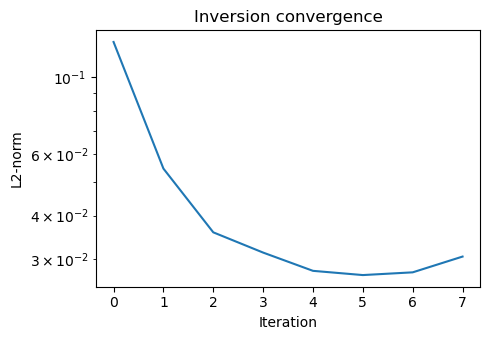

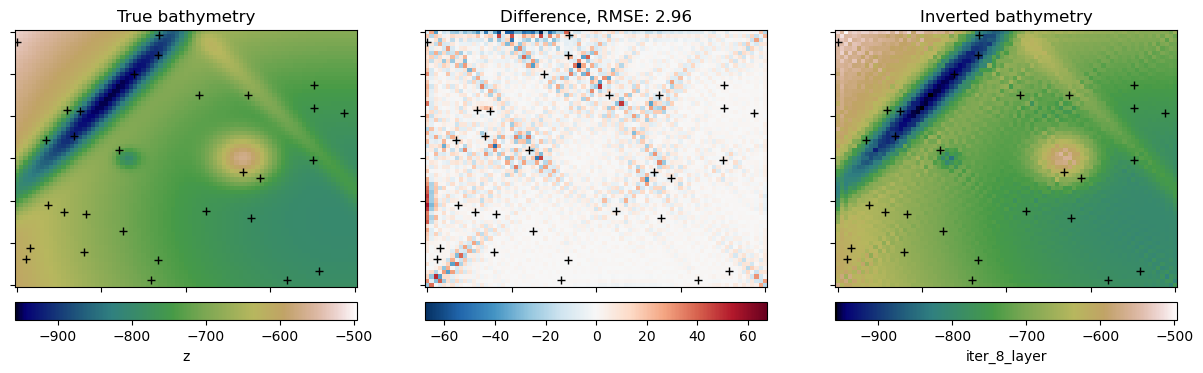

In [35]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    solver_damping=10**-4,
    plot_convergence=True,
)

with inv_utils.HiddenPrints():
    results = inv.inversion_RMSE(
        input_grav=full_res_grav[full_res_grav.test == False],
        # input_grav=sampled_grav,
        inversion_region=inversion_region,
        true_surface=layer1,
        constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
        plot=True,
        plot_type="xarray",
        **kwargs,
    )

(
    rmse,
    prism_results,
    grav_results,
    params,
    elapsed_time,
    constraints_rmse,
) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,

#         grav_spacing=grav_spacing,
#         # grav_spacing=sampled_grav_spacing,

#         constraints=constraints,
#     )

print(f"RMSE: {rmse}")
print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [46]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_no_reg_inversion_hyperparameters_fullres"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [47]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=full_res_grav[full_res_grav.test == False],
    testing_data=full_res_grav[full_res_grav.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

[I 2023-04-21 20:33:16,183] A new study created in Journal with name: synthetic_simple_no_reg_inversion_hyperparameters_fullres


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

FrozenTrial(number=35, state=TrialState.COMPLETE, values=[0.0014034642373925027], datetime_start=datetime.datetime(2023, 4, 21, 20, 33, 41, 64669), datetime_complete=datetime.datetime(2023, 4, 21, 20, 41, 7, 506276), params={'damping': -2, 'weights_outer': 3000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=10000, log=False, low=2000, step=1000)}, trial_id=35, value=None)


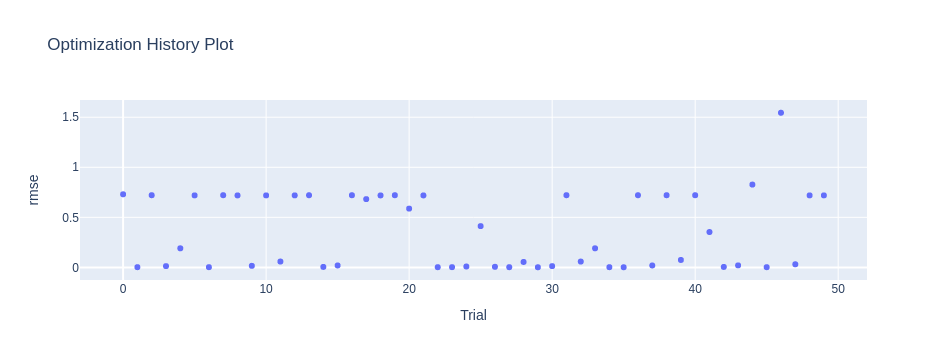

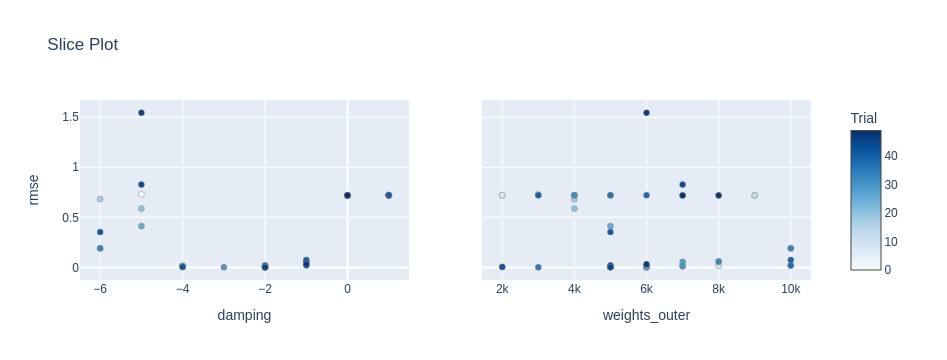

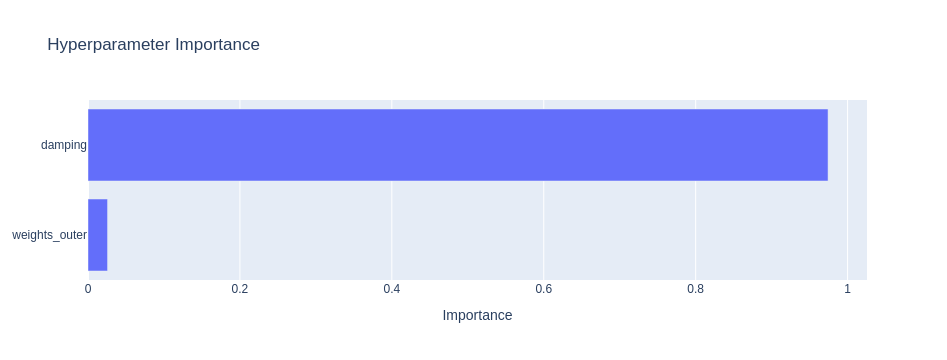

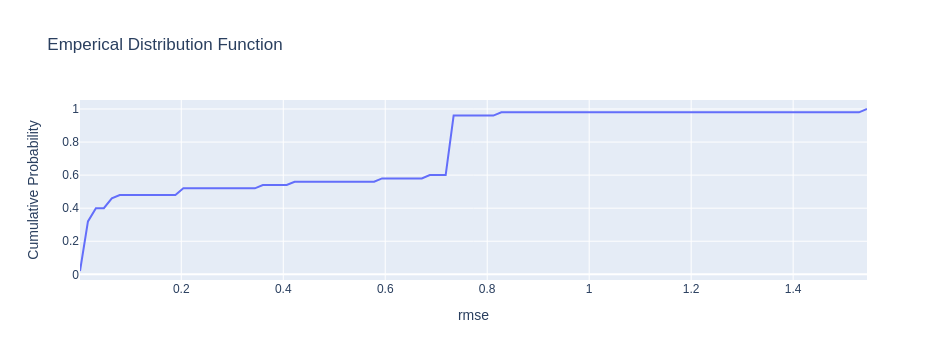

In [48]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

{'damping': -2, 'weights_outer': 3000}


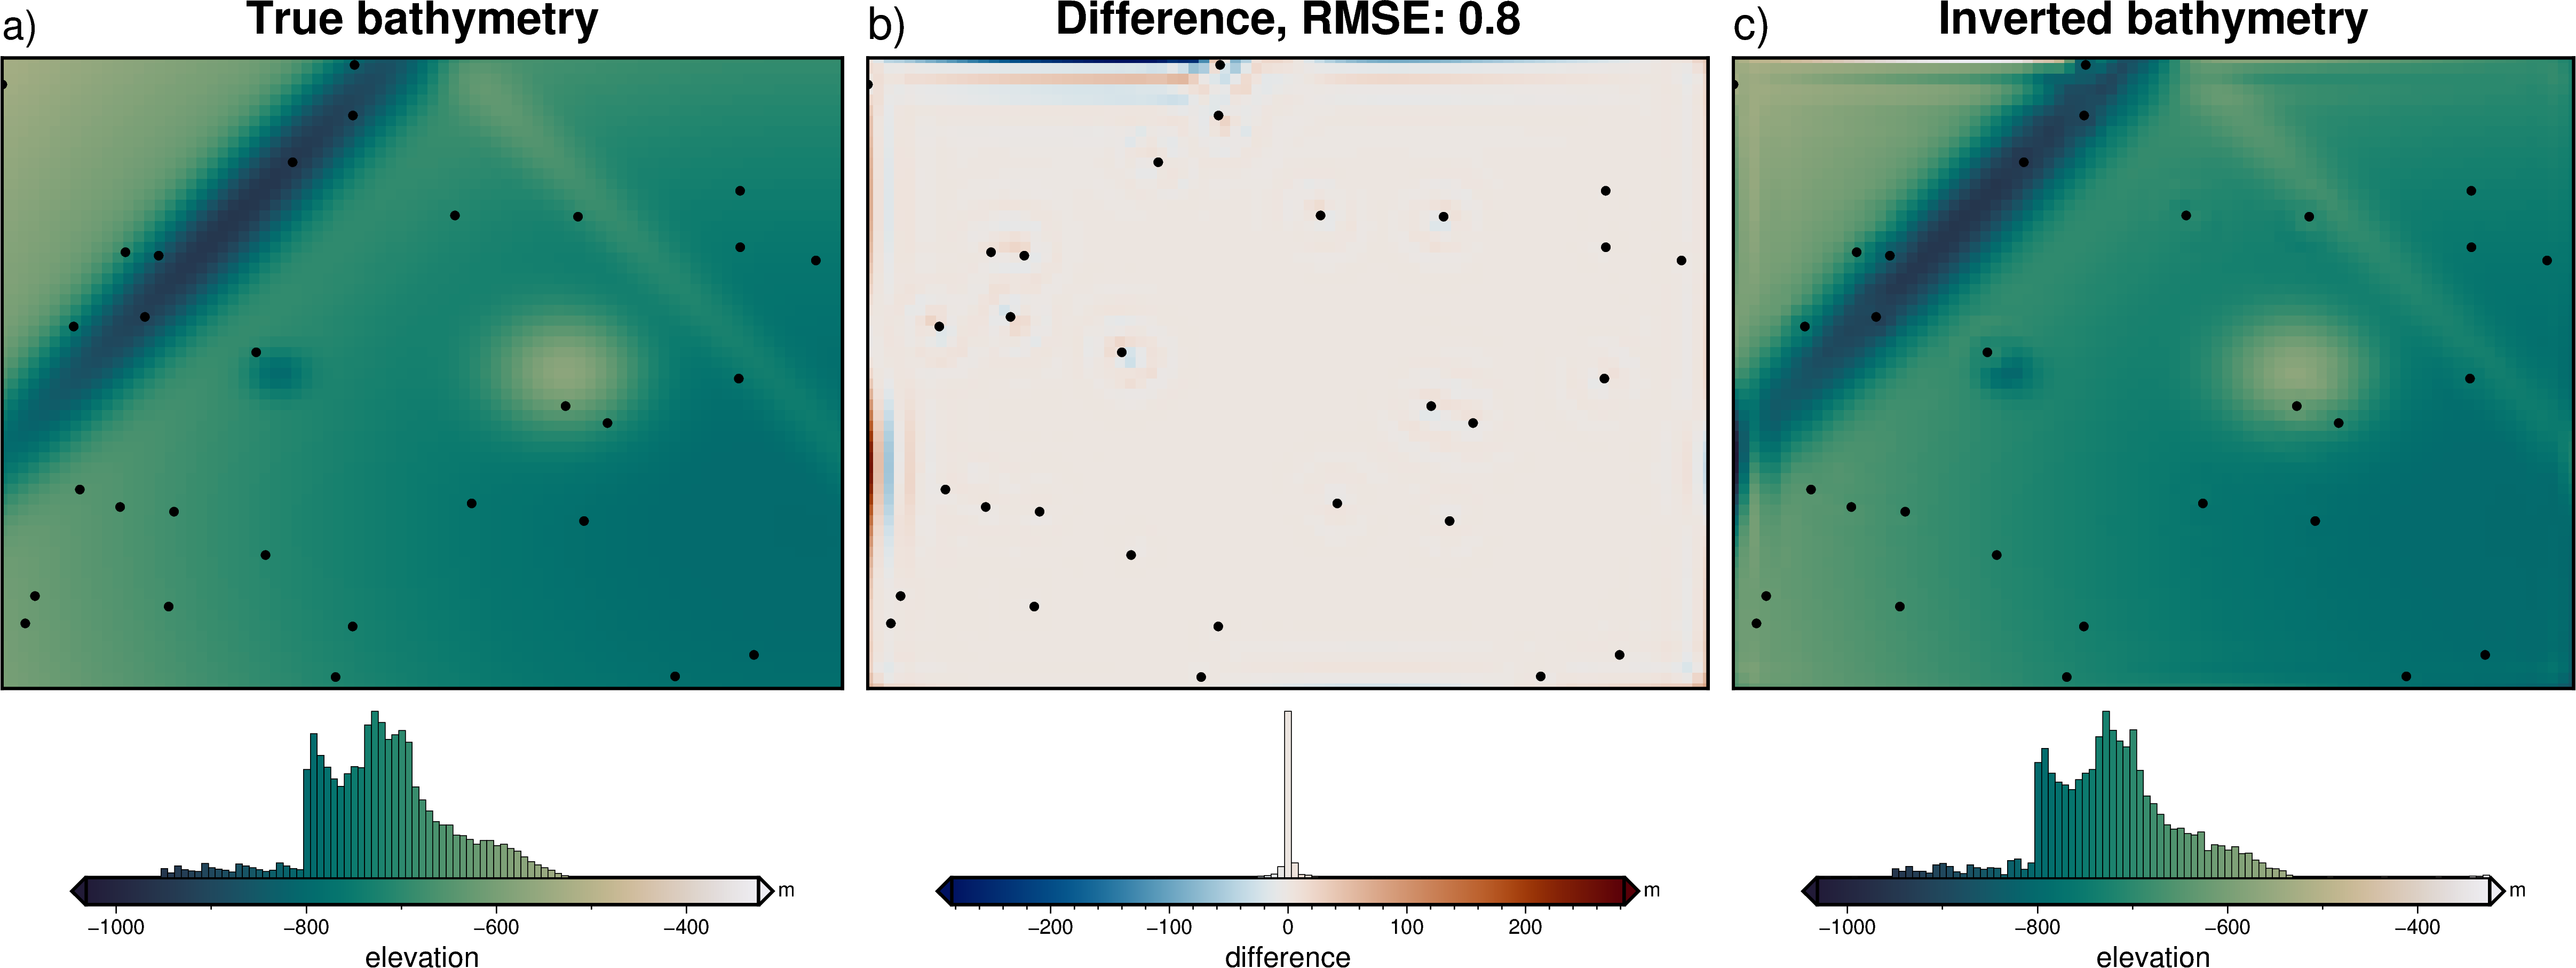

RMSE between surfaces at constraints: 0.36 m


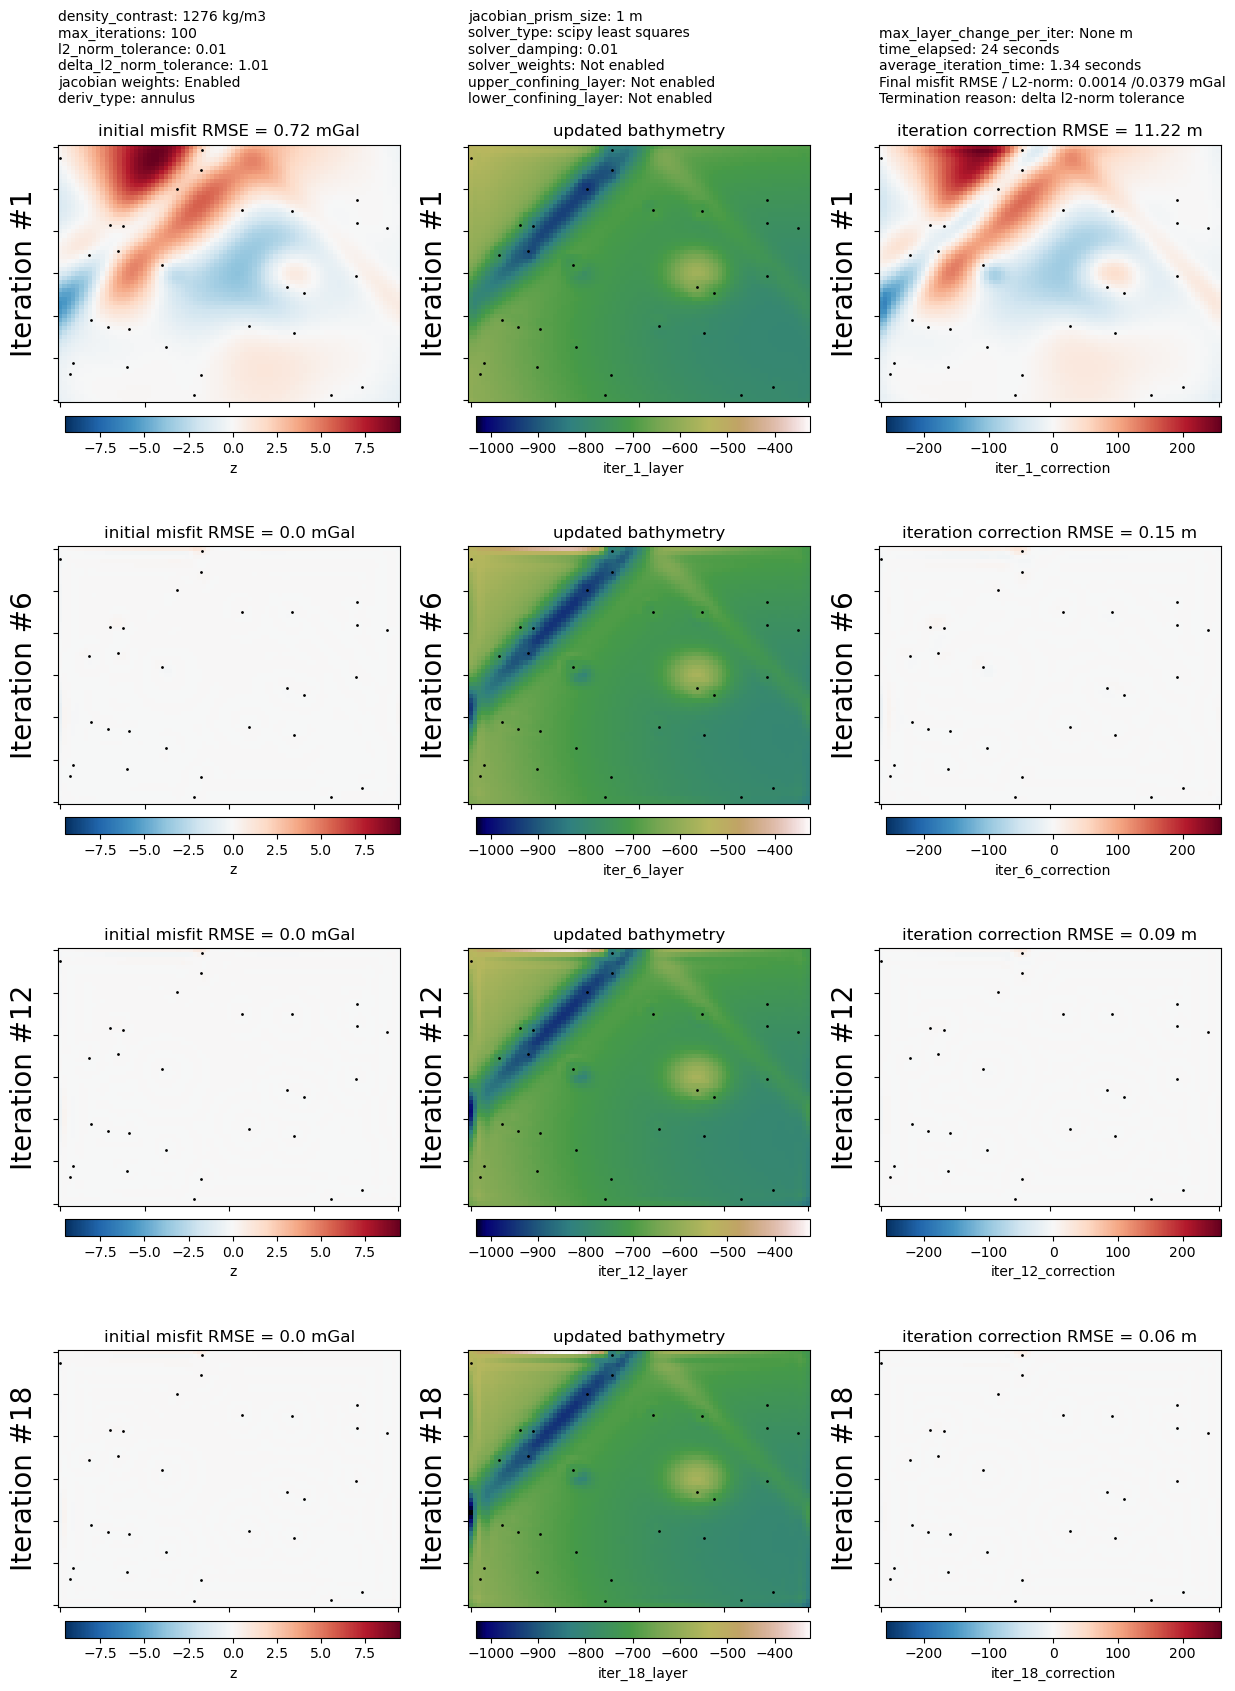

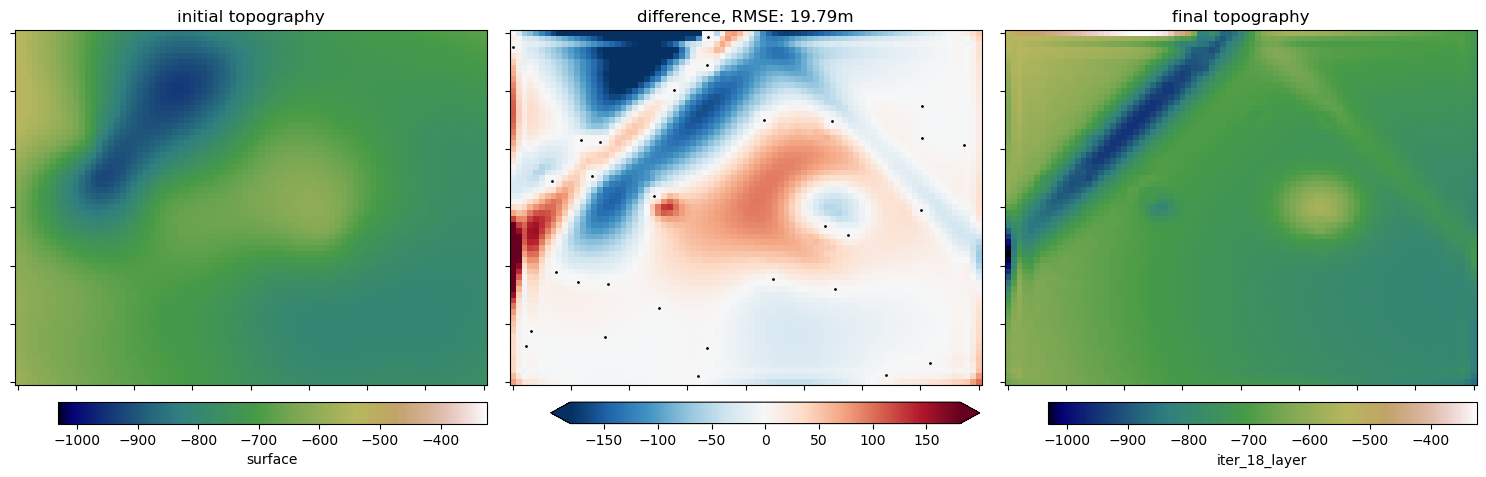

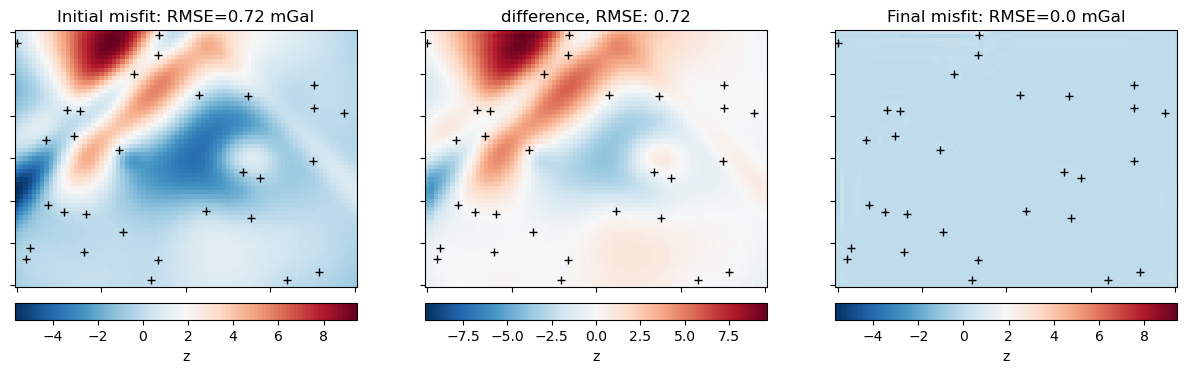

In [49]:
print(study.best_params)
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=full_res_grav[full_res_grav.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

### Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [50]:
# contaminate with noise
full_res_grav_noise = full_res_grav.copy()
full_res_grav_noise["Gobs"] = synthetic.contaminate(
    full_res_grav_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
full_res_grav_noise = inv.misfit(
    input_grav=full_res_grav_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)
# set regional to 0
full_res_grav_noise["reg"] = 0
full_res_grav_noise["res"] = full_res_grav_noise.misfit
print(full_res_grav_noise.res.median())

full_res_grav_noise

Standard deviation used for noise: [0.16382499594057567]
DC shifted observed gravity by -0.54mGal to match forward gravity.
0.21665746138760067


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  5.185691 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.898845 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.925377 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  5.059999 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.923527 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.638063  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.922292  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.892272  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.965702  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.989985  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift  reg       res    misfit  
0            6.004718    5.730325    0 -0.274393 -0.274393  
1            5.879250    5.443479    0 -0.435771 -0.435771  
2            5.751148    5.470012    0 -0.281137 -0.281137  
3            5.621796    5.604633    0 -0.017162 -0.017162  
4            5.492230    5.468162    0 -0.024068 -0.024068  
...               ...         ...  ...       ...       ...  
19476        1.432526    1.182697    0 -0.249829 -0.249829  
19477        1.480172    1.466927    0 -0.013245 -0.013245  
19478        1.528039    1.436906    0 -0.091133 -0.091133  
19479        1.575824    1.510336    0 -0.065488 -0.065488  
19480        1.623114    1.534620    0 -0.088494 -0.088494  

[19481 rows x 12 columns]

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


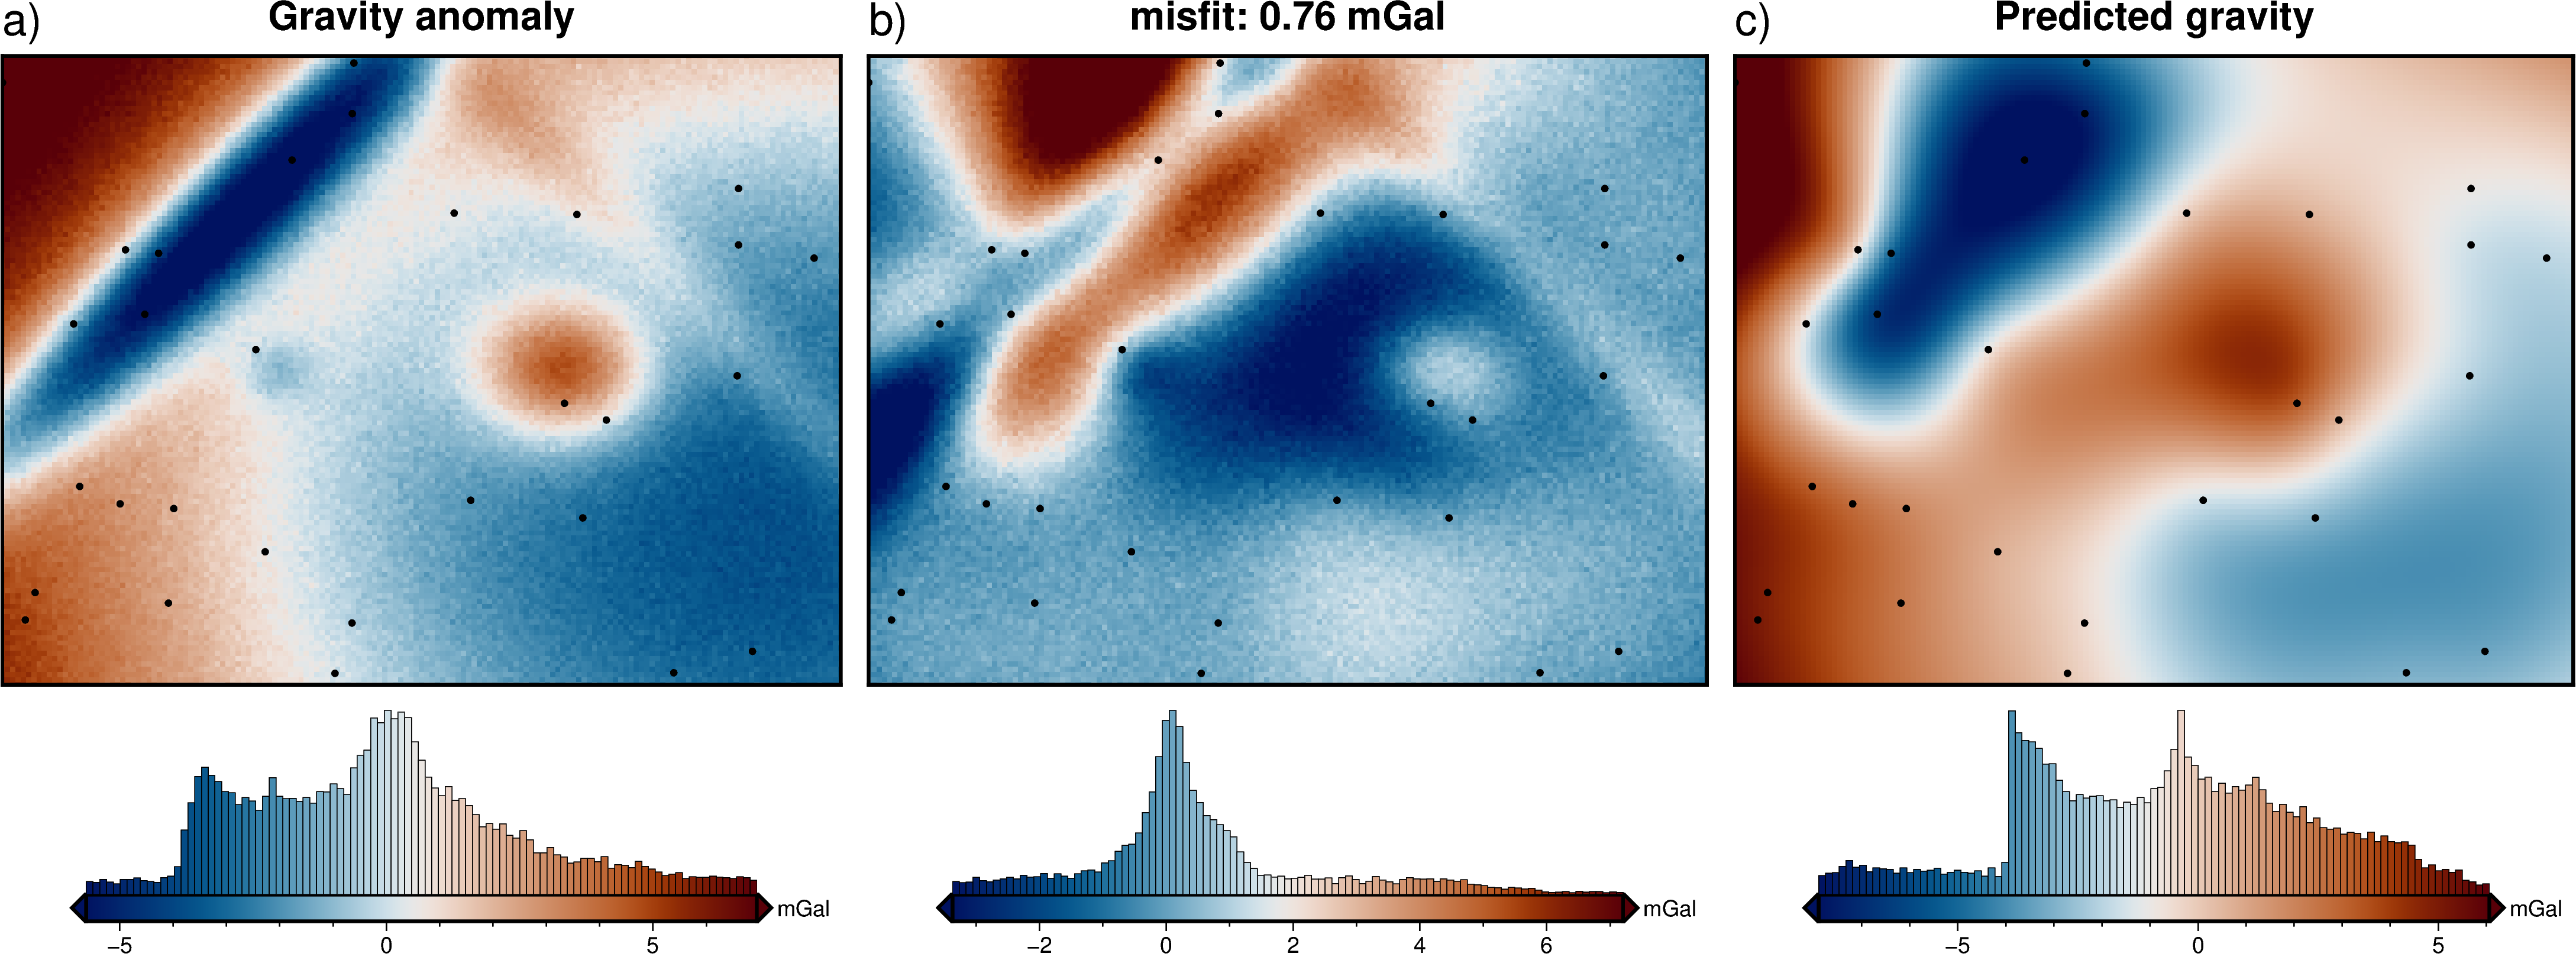

In [51]:
plotting.misfit_plotting(
    full_res_grav_noise,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [52]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_no_reg_inversion_hyperparameters_noise"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [53]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=full_res_grav_noise[full_res_grav_noise.test == False],
    testing_data=full_res_grav_noise[full_res_grav_noise.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

[I 2023-04-21 20:56:32,889] A new study created in Journal with name: synthetic_simple_no_reg_inversion_hyperparameters_noise


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

FrozenTrial(number=28, state=TrialState.COMPLETE, values=[0.11637560291976405], datetime_start=datetime.datetime(2023, 4, 21, 20, 56, 52, 222190), datetime_complete=datetime.datetime(2023, 4, 21, 20, 58, 49, 104323), params={'damping': -2, 'weights_outer': 2000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=10000, log=False, low=2000, step=1000)}, trial_id=28, value=None)


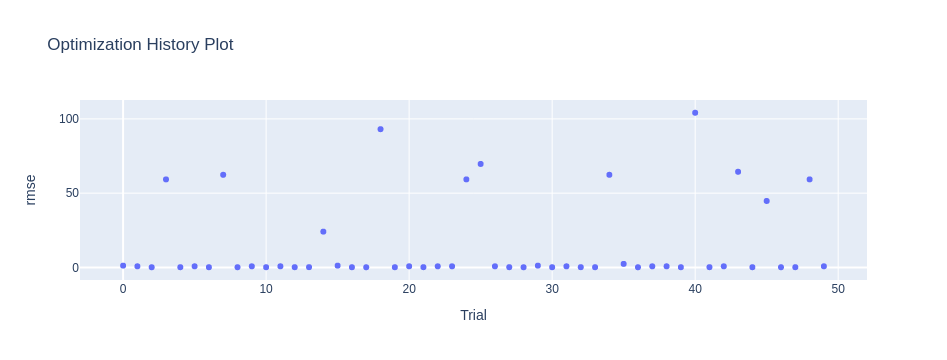

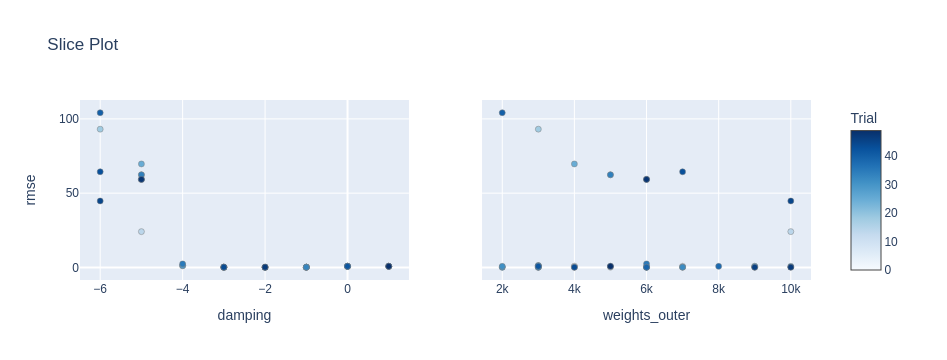

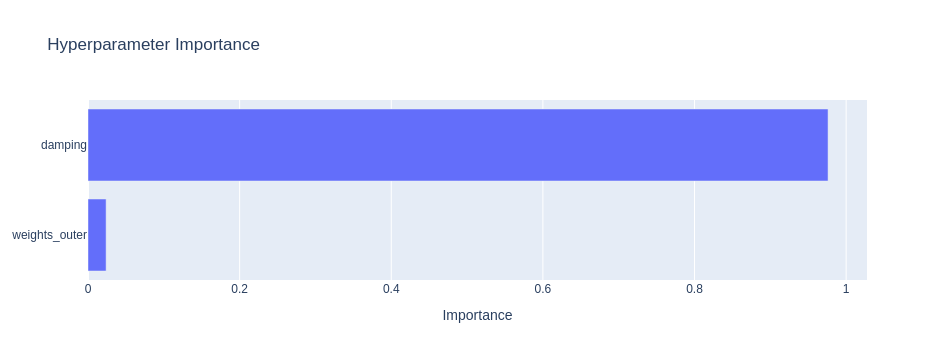

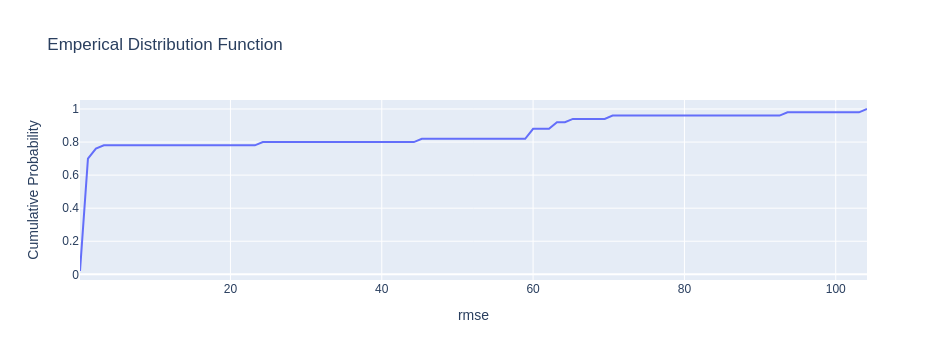

In [54]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

In [55]:
study_df.head()

number      value             datetime_start          datetime_complete  \
0       0   1.193569 2023-04-21 20:56:32.944632 2023-04-21 20:59:30.373283   
1       1   0.758151 2023-04-21 20:56:33.716708 2023-04-21 20:57:31.020312   
2       2   0.117402 2023-04-21 20:56:33.722393 2023-04-21 20:58:30.516694   
3       3  59.259148 2023-04-21 20:56:33.727656 2023-04-21 21:03:23.045936   
4       4   0.146059 2023-04-21 20:56:33.730048 2023-04-21 21:00:18.689465   

                duration  params_damping  params_weights_outer     state  
0 0 days 00:02:57.428651              -4                  3000  COMPLETE  
1 0 days 00:00:57.303604               1                  4000  COMPLETE  
2 0 days 00:01:56.794301              -2                  4000  COMPLETE  
3 0 days 00:06:49.318280              -5                  6000  COMPLETE  
4 0 days 00:03:44.959417              -3                  9000  COMPLETE

In [56]:
study.best_params

{'damping': -2, 'weights_outer': 2000}

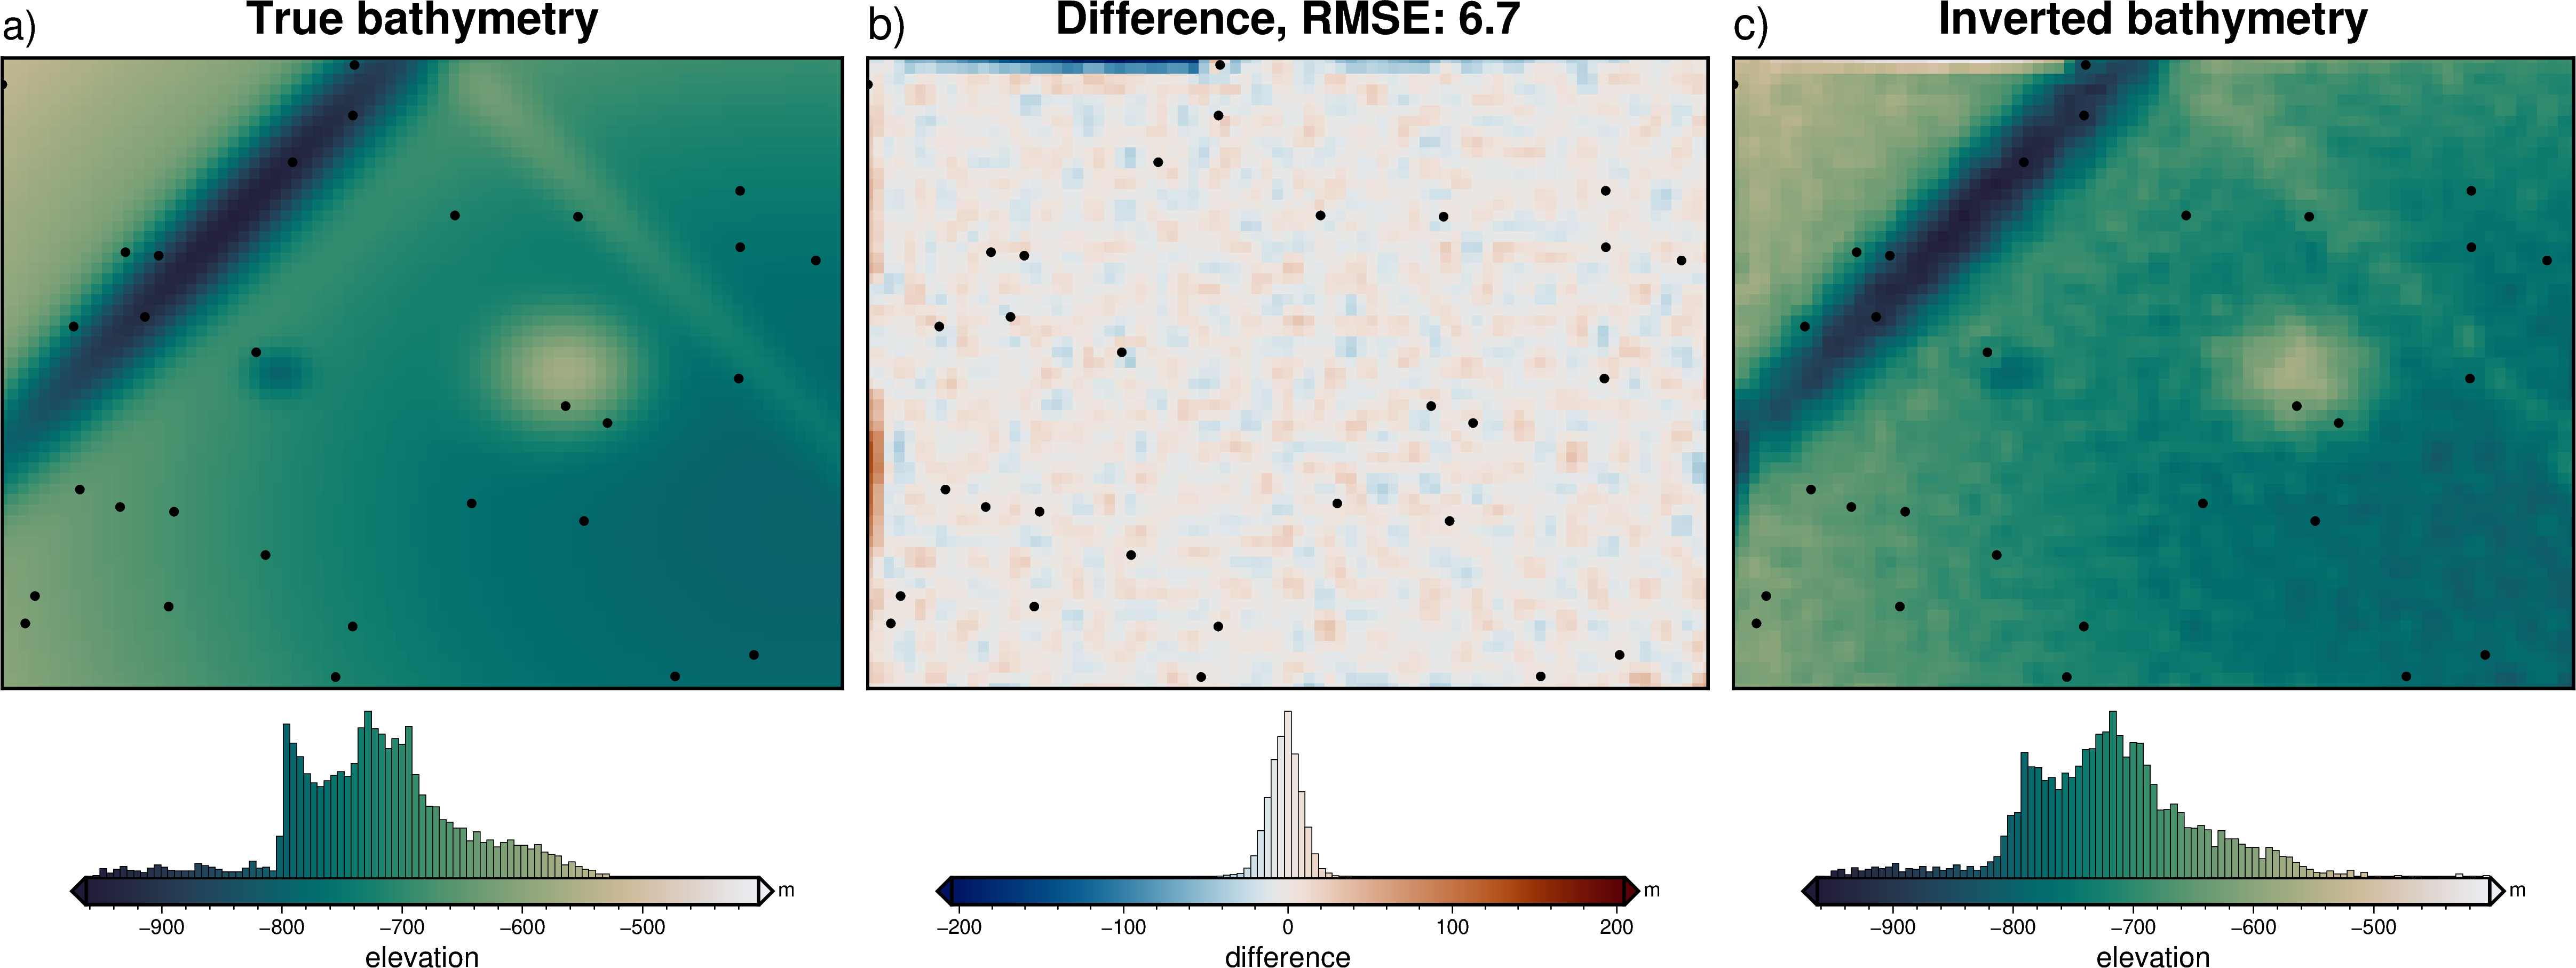

RMSE between surfaces at constraints: 0.48 m


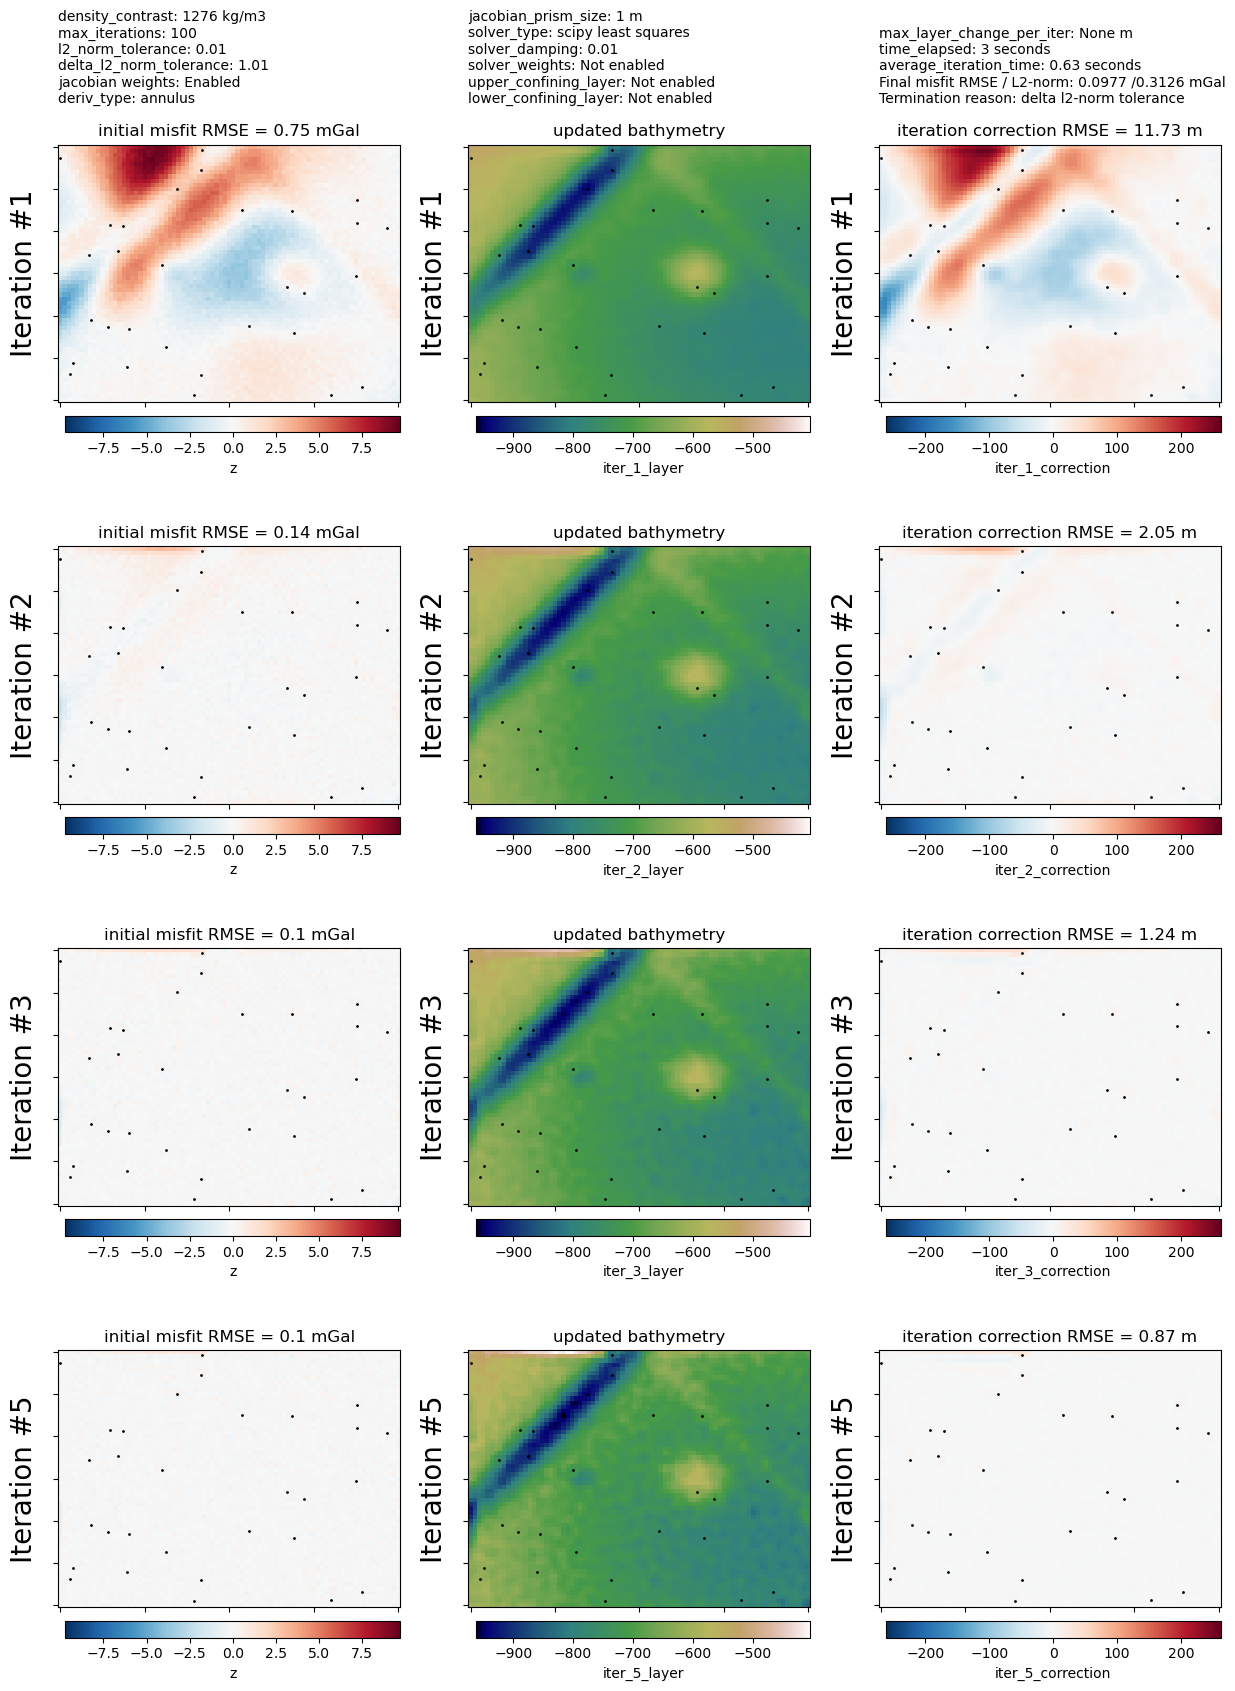

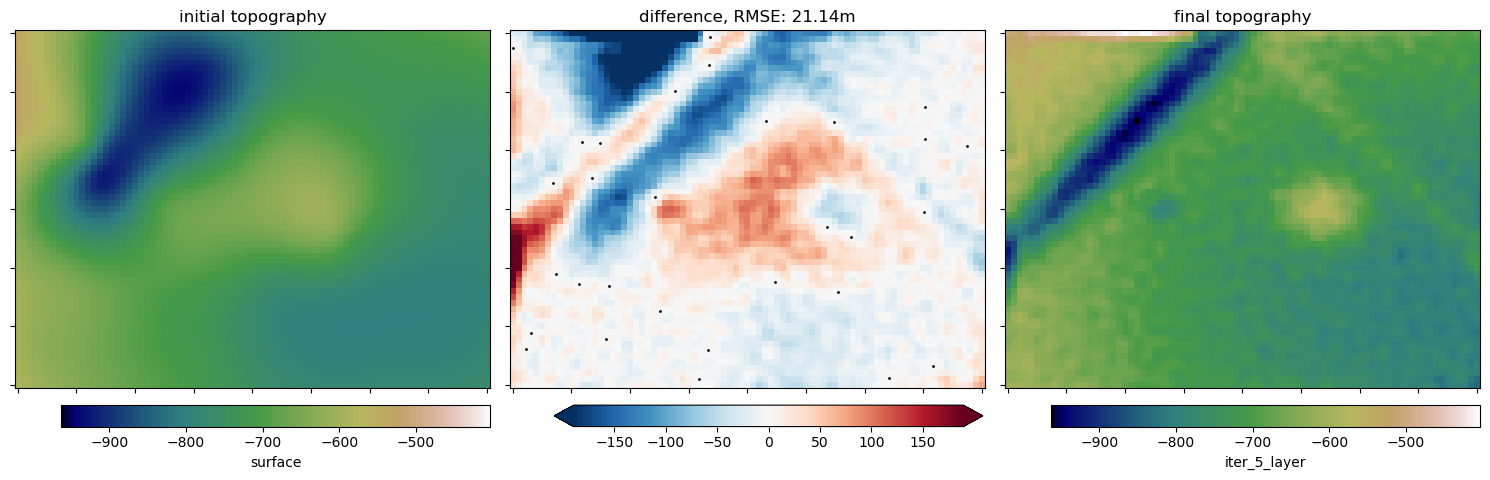

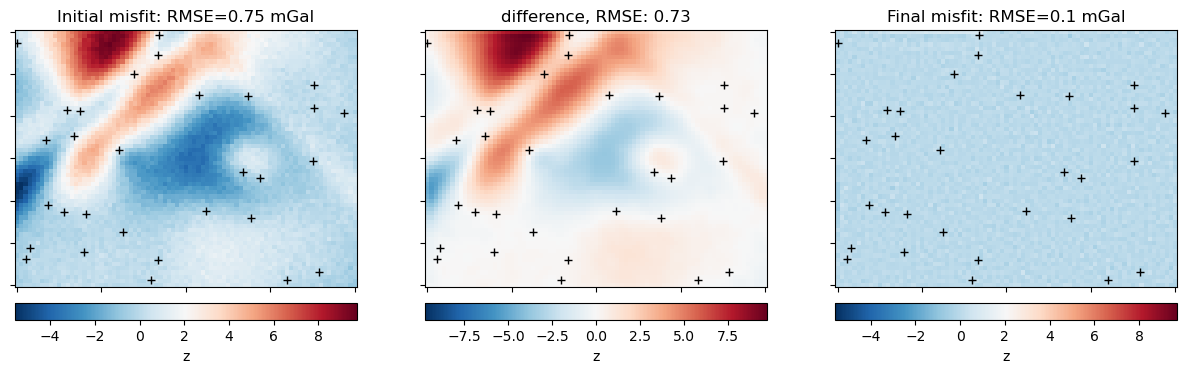

In [57]:
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=full_res_grav_noise[full_res_grav_noise.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

## Repeat with sampled data

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


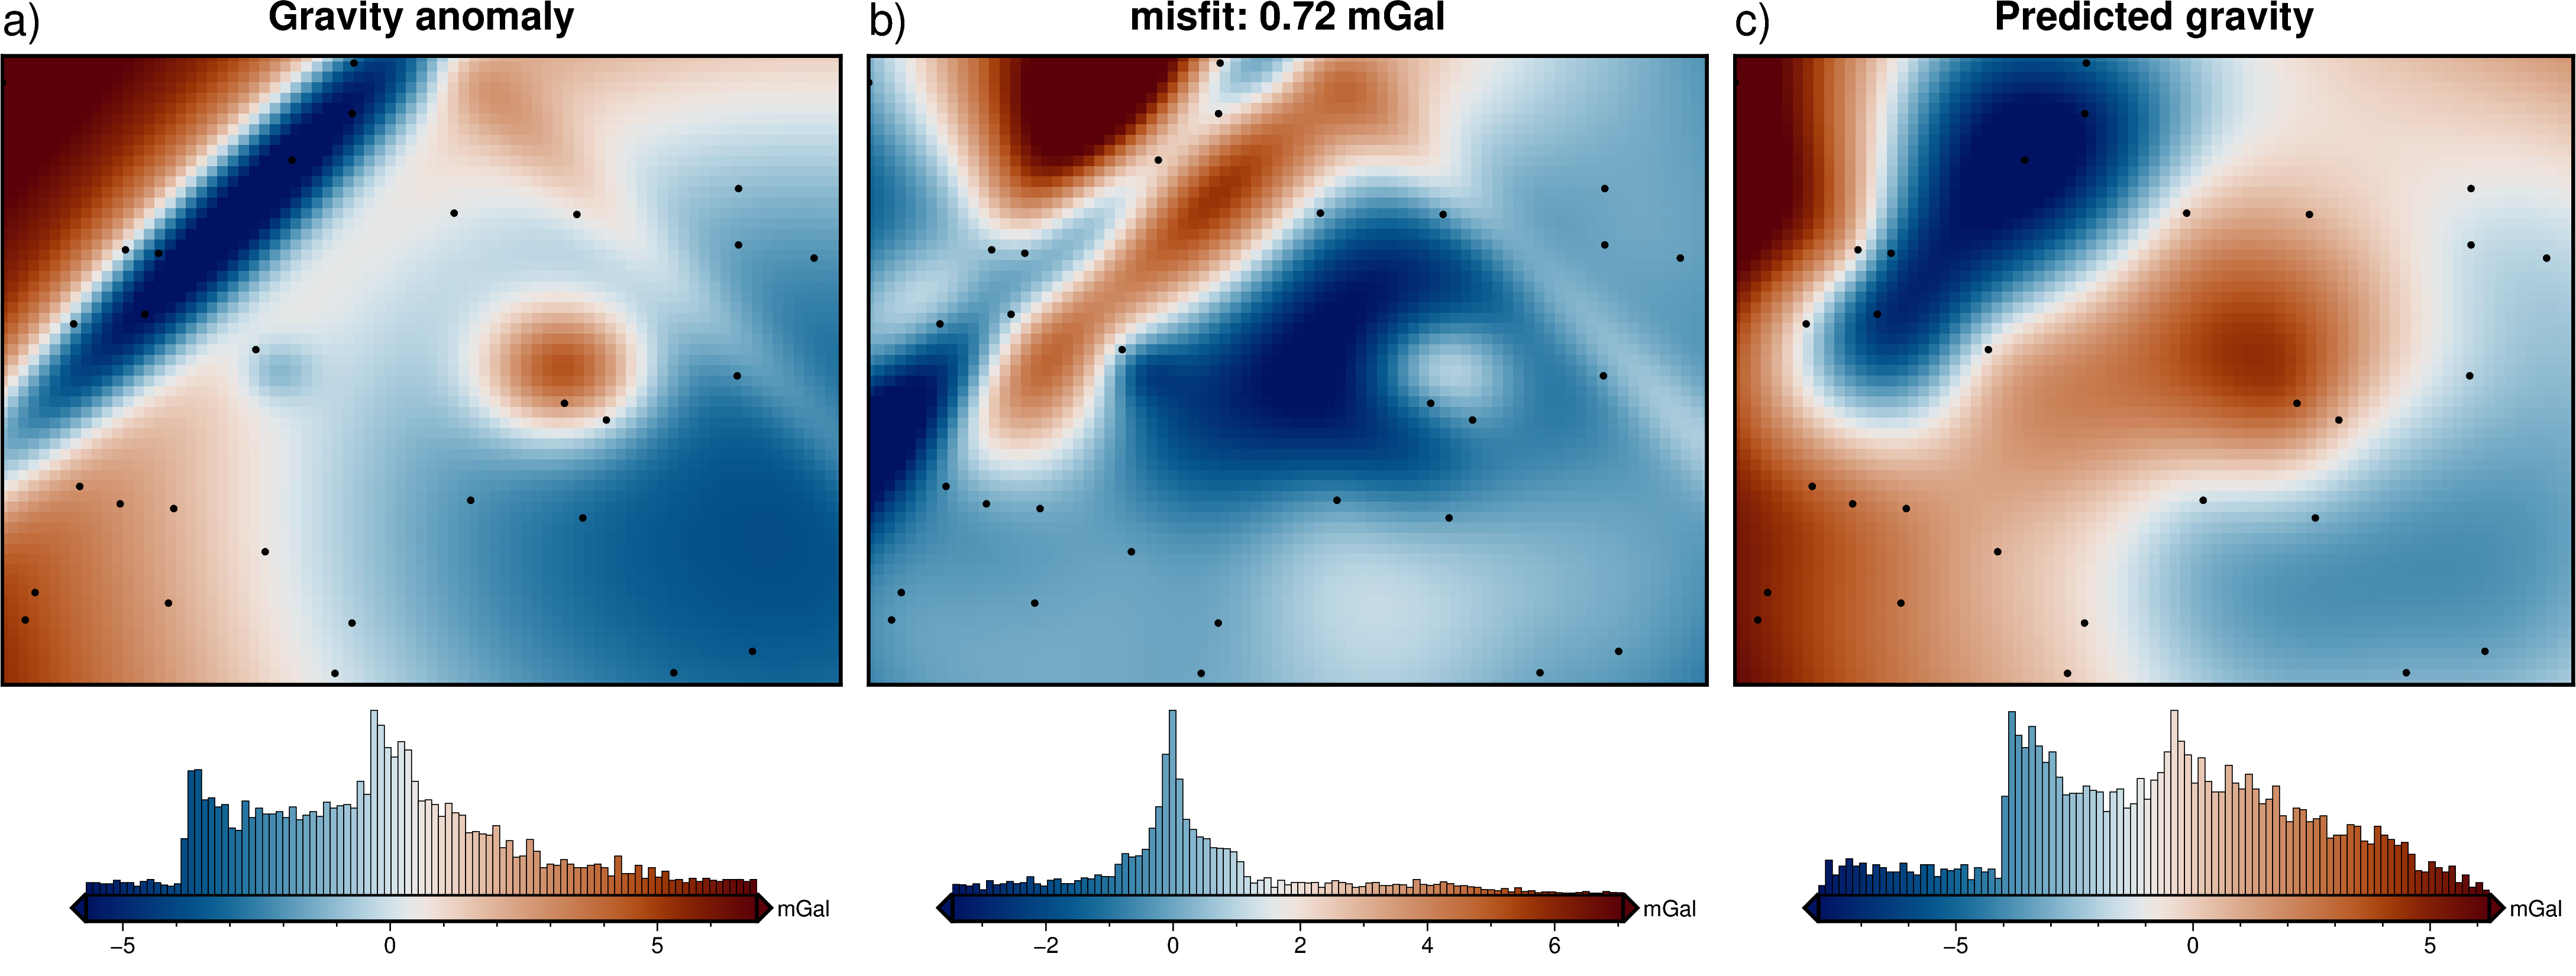

In [88]:
plotting.misfit_plotting(
    sampled_grav,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [89]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_no_reg_inversion_hyperparameters"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [90]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=sampled_grav[sampled_grav.test == False],
    testing_data=sampled_grav[sampled_grav.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

[I 2023-04-21 22:28:11,734] A new study created in Journal with name: synthetic_simple_sampled_no_reg_inversion_hyperparameters


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

FrozenTrial(number=43, state=TrialState.COMPLETE, values=[0.0015015152649943532], datetime_start=datetime.datetime(2023, 4, 21, 22, 28, 34, 26033), datetime_complete=datetime.datetime(2023, 4, 21, 22, 30, 39, 545396), params={'damping': -4, 'weights_outer': 2000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=10000, log=False, low=2000, step=1000)}, trial_id=43, value=None)


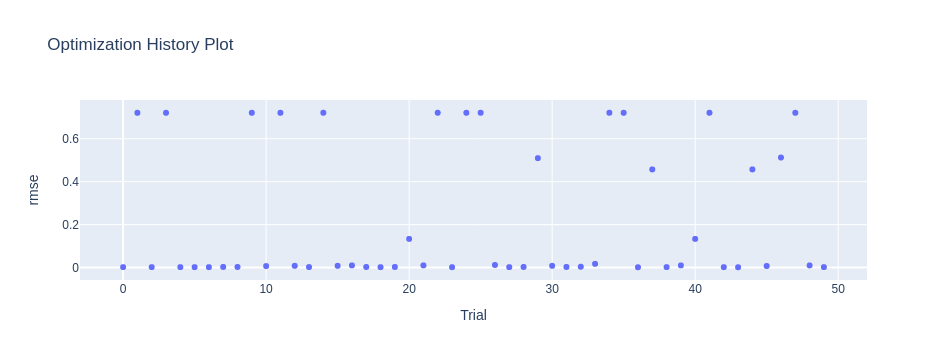

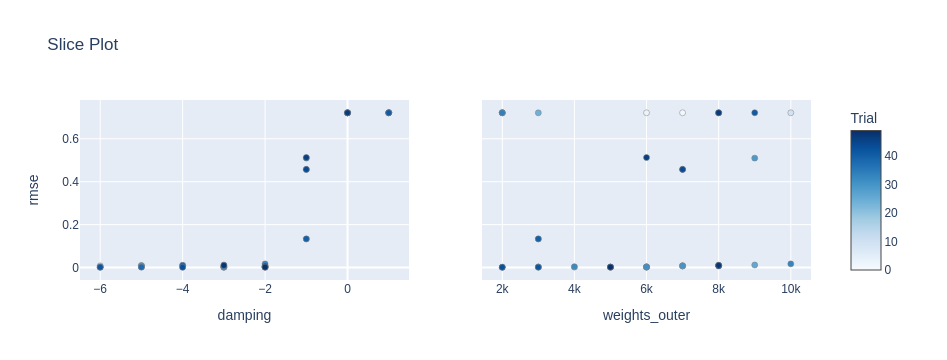

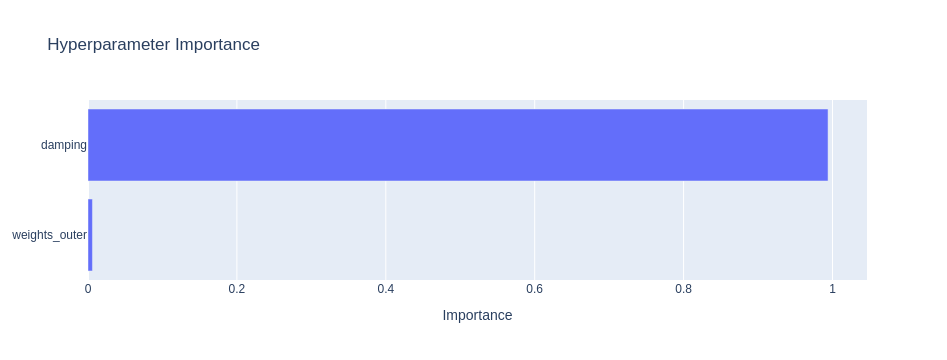

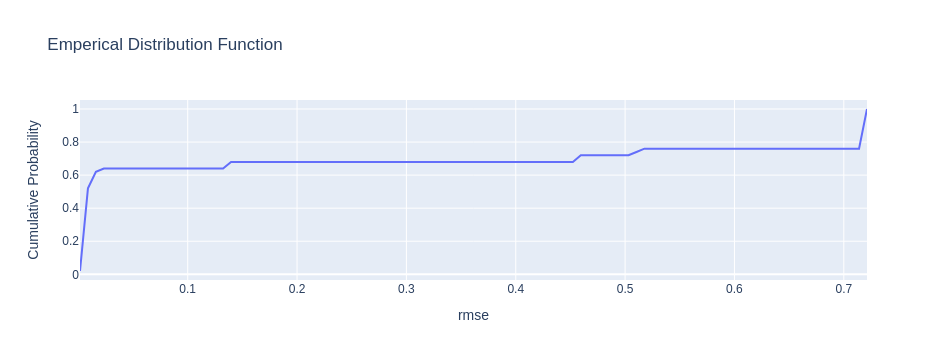

In [91]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

In [92]:
study_df.head()

number     value             datetime_start          datetime_complete  \
0       0  0.002112 2023-04-21 22:28:24.677741 2023-04-21 22:31:18.067052   
1       1  0.721018 2023-04-21 22:28:25.276163 2023-04-21 22:28:38.825578   
2       2  0.002112 2023-04-21 22:28:25.765569 2023-04-21 22:32:32.027762   
3       3  0.721013 2023-04-21 22:28:26.171563 2023-04-21 22:28:40.315946   
4       4  0.002095 2023-04-21 22:28:26.664100 2023-04-21 22:32:40.789947   

                duration  params_damping  params_weights_outer     state  
0 0 days 00:02:53.389311              -2                  5000  COMPLETE  
1 0 days 00:00:13.549415               0                  7000  COMPLETE  
2 0 days 00:04:06.262193              -2                  5000  COMPLETE  
3 0 days 00:00:14.144383               0                  6000  COMPLETE  
4 0 days 00:04:14.125847              -4                  5000  COMPLETE

In [93]:
study.best_params

{'damping': -4, 'weights_outer': 2000}

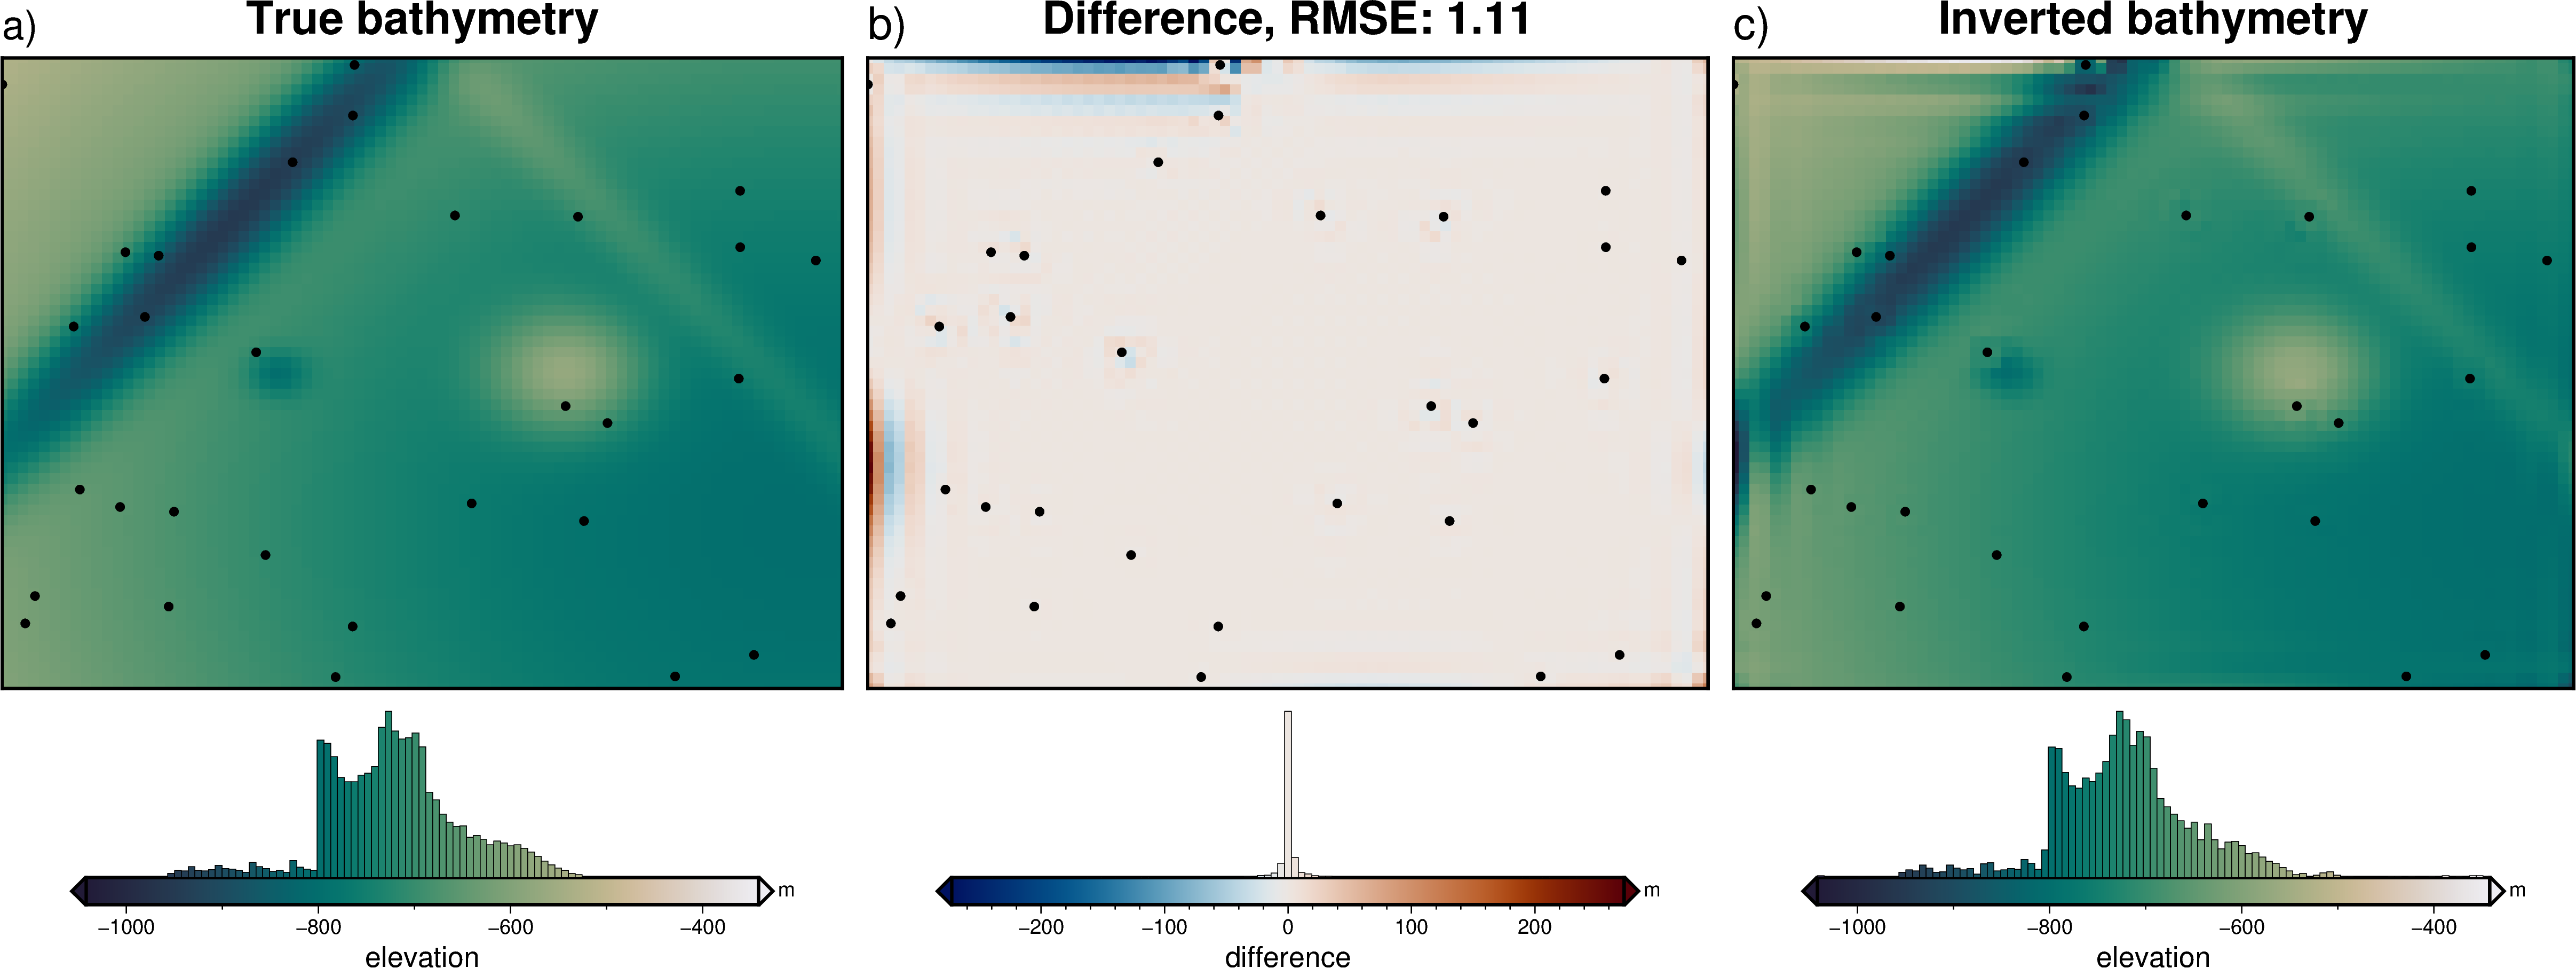

RMSE between surfaces at constraints: 0.5 m


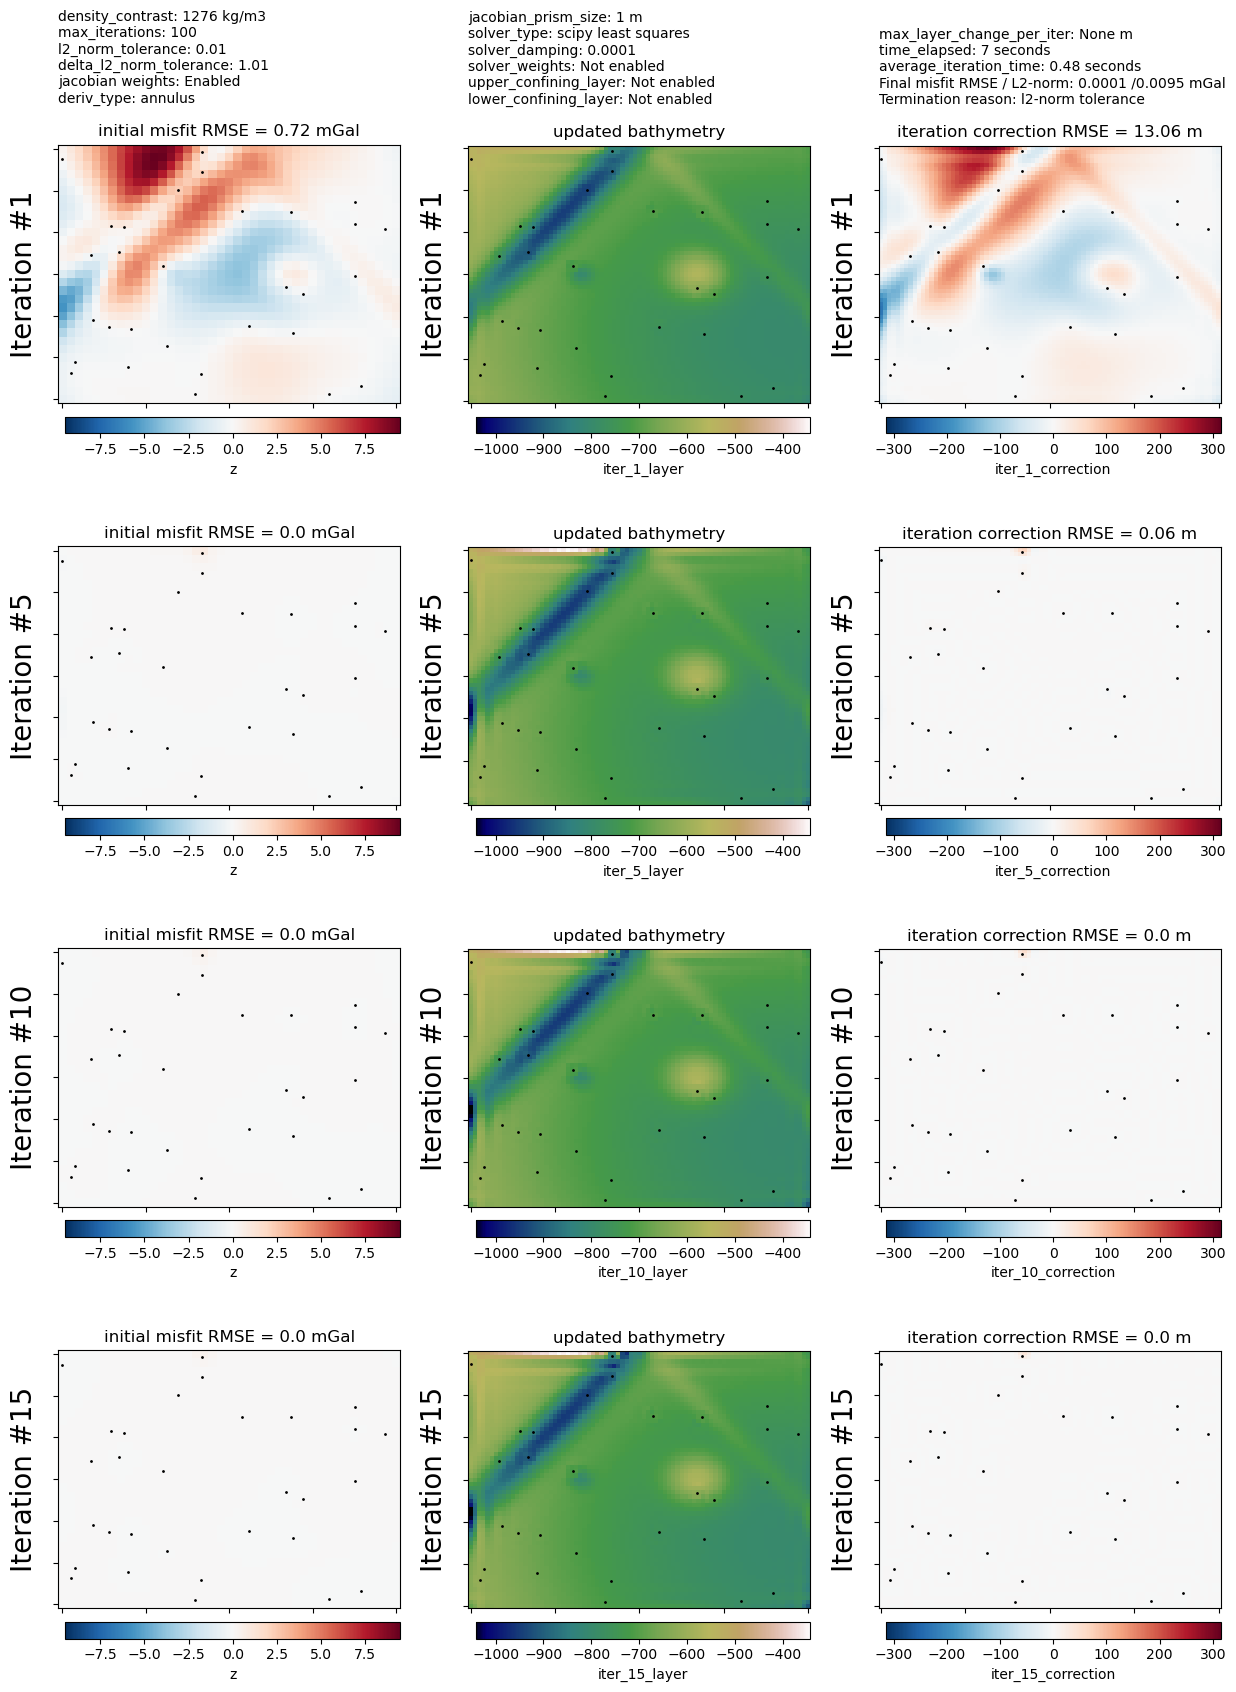

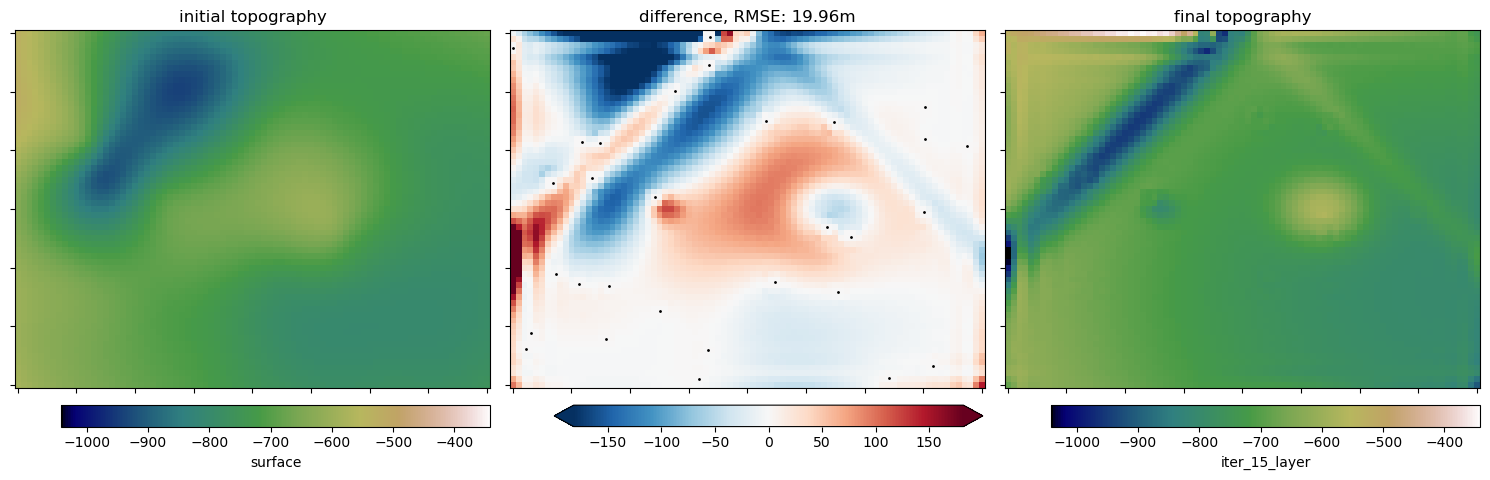

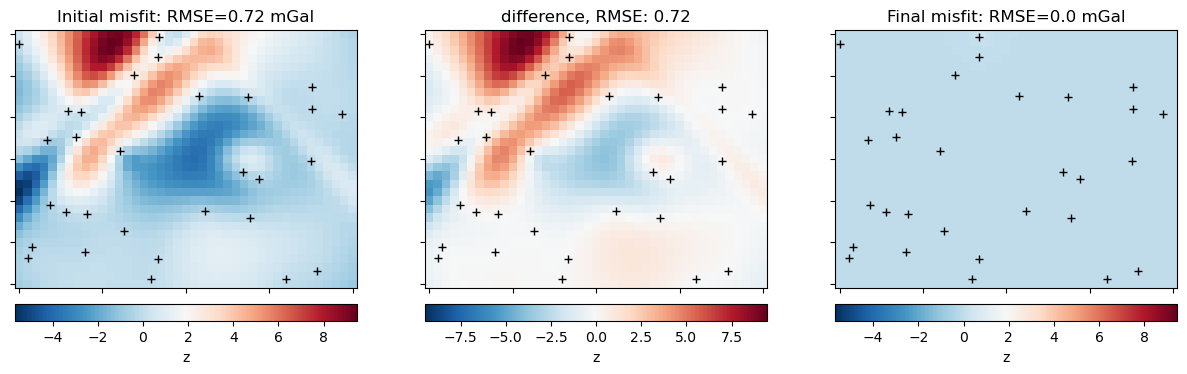

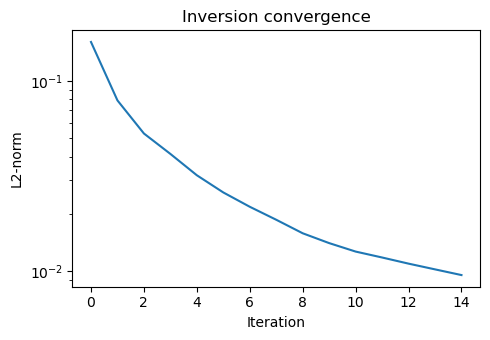

In [94]:
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=sampled_grav[sampled_grav.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

### Add noise

In [58]:
# contaminate with noise
sampled_grav_noise = sampled_grav.copy()
sampled_grav_noise["Gobs"] = synthetic.contaminate(
    sampled_grav_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
sampled_grav_noise = inv.misfit(
    input_grav=sampled_grav_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)
# set regional to 0
sampled_grav_noise["reg"] = 0
sampled_grav_noise["res"] = sampled_grav_noise.misfit
print(sampled_grav_noise.res.median())

sampled_grav_noise

Standard deviation used for noise: [0.16382499694820002]
DC shifted observed gravity by -0.38mGal to match forward gravity.
0.0573333309080134


northing  easting  upward   test      Gobs  layer1_forward  Gobs_shift  \
0          0.0      0.0  1000.0  False  5.187848        6.004718    5.568219   
1          0.0   1000.0  1000.0   True  4.832748        5.751148    5.213119   
2          0.0   2000.0  1000.0  False  4.780074        5.492230    5.160445   
3          0.0   3000.0  1000.0   True  4.828969        5.235439    5.209340   
4          0.0   4000.0  1000.0  False  4.602930        4.984941    4.983301   
...        ...      ...     ...    ...       ...             ...         ...   
4936   60000.0  76000.0  1000.0  False  0.775057        1.247832    1.155428   
4937   60000.0  77000.0  1000.0   True  0.718067        1.338739    1.098438   
4938   60000.0  78000.0  1000.0  False  0.668715        1.432526    1.049086   
4939   60000.0  79000.0  1000.0   True  0.922175        1.528039    1.302546   
4940   60000.0  80000.0  1000.0  False  0.748611        1.623114    1.128982   

      reg       res    misfit  
0       0 -0.436499 -0.436499  
1       0 -0.538029 -0.538029  
2       0 -0.331785 -0.331785  
3       0 -0.026099 -0.026099  
4       0 -0.001640 -0.001640  
...   ...       ...       ...  
4936    0 -0.092404 -0.092404  
4937    0 -0.240302 -0.240302  
4938    0 -0.383440 -0.383440  
4939    0 -0.225494 -0.225494  
4940    0 -0.494132 -0.494132  

[4941 rows x 10 columns]

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


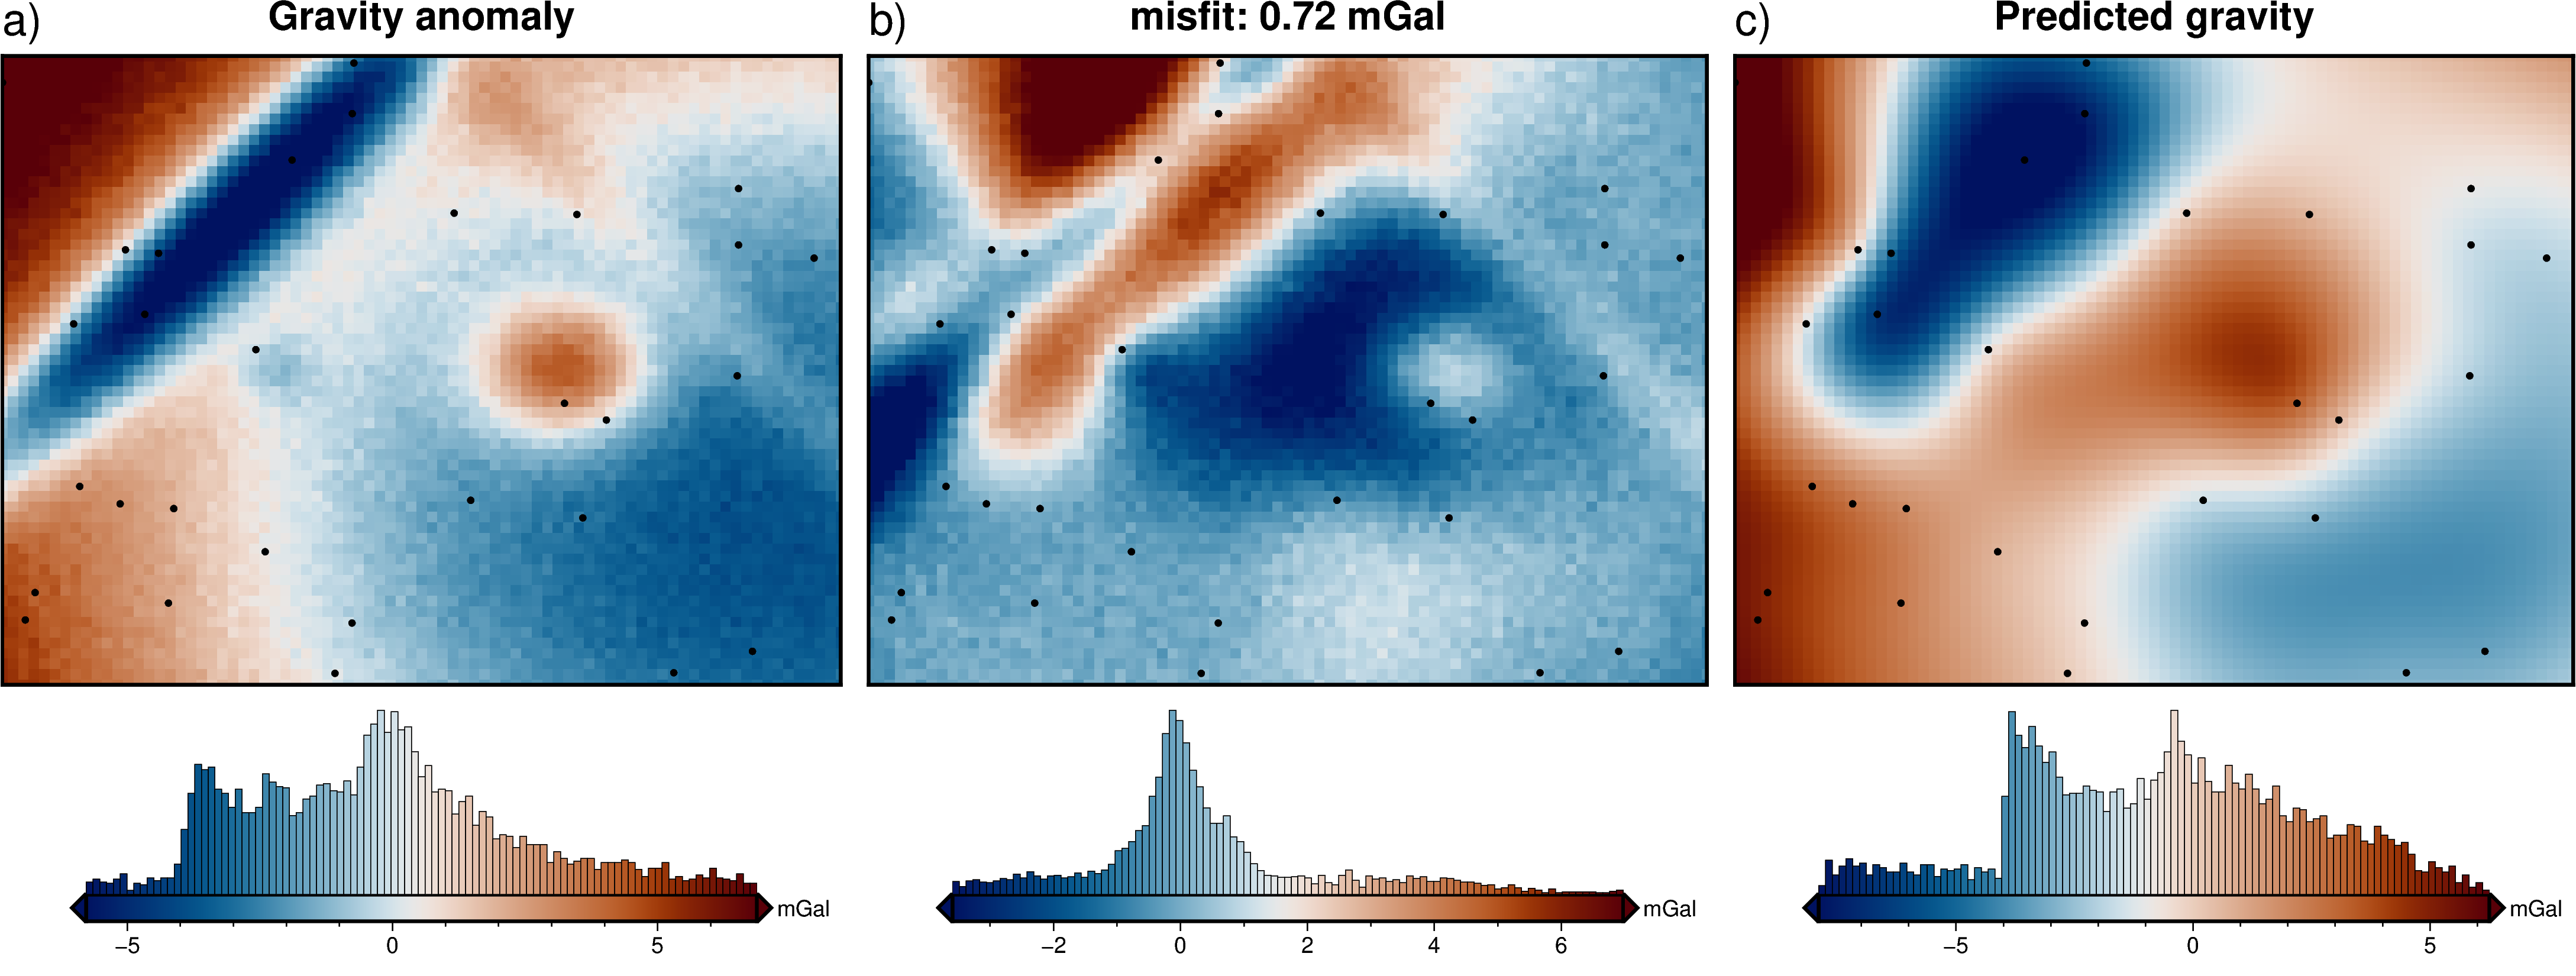

In [59]:
plotting.misfit_plotting(
    sampled_grav_noise,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [60]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_noise_no_reg_inversion_hyperparameters"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [61]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=sampled_grav_noise[sampled_grav_noise.test == False],
    testing_data=sampled_grav_noise[sampled_grav_noise.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

[I 2023-04-21 21:18:06,048] A new study created in Journal with name: synthetic_simple_sampled_noise_no_reg_inversion_hyperparameters


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.13869148468038853], datetime_start=datetime.datetime(2023, 4, 21, 21, 18, 15, 455701), datetime_complete=datetime.datetime(2023, 4, 21, 21, 19, 31, 456540), params={'damping': -2, 'weights_outer': 6000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=10000, log=False, low=2000, step=1000)}, trial_id=9, value=None)


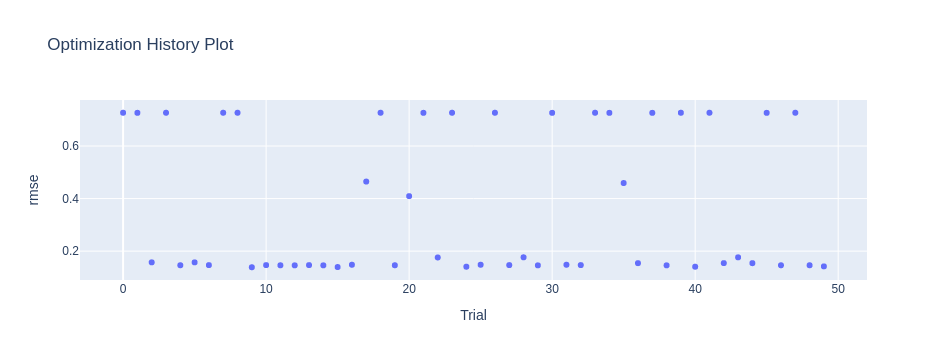

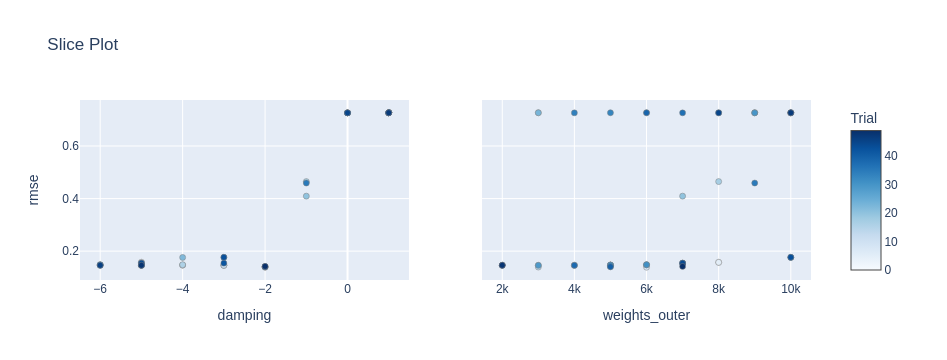

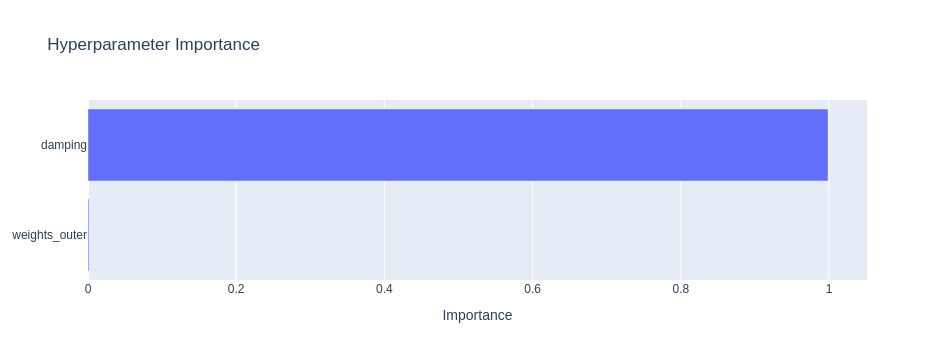

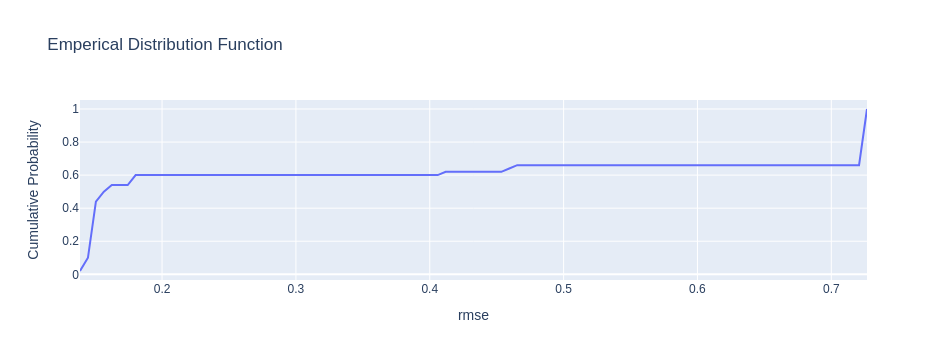

In [62]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

In [63]:
study_df.head()

number     value             datetime_start          datetime_complete  \
0       0  0.726670 2023-04-21 21:18:14.336392 2023-04-21 21:18:27.132093   
1       1  0.726358 2023-04-21 21:18:15.202637 2023-04-21 21:18:28.427915   
2       2  0.157350 2023-04-21 21:18:15.321081 2023-04-21 21:19:47.621706   
3       3  0.726670 2023-04-21 21:18:15.779911 2023-04-21 21:19:12.363323   
4       4  0.146290 2023-04-21 21:18:16.208568 2023-04-21 21:21:08.701614   

                duration  params_damping  params_weights_outer     state  
0 0 days 00:00:12.795701               1                  3000  COMPLETE  
1 0 days 00:00:13.225278               0                 10000  COMPLETE  
2 0 days 00:01:32.300625              -5                  8000  COMPLETE  
3 0 days 00:00:56.583412               1                  6000  COMPLETE  
4 0 days 00:02:52.493046              -3                  4000  COMPLETE

In [64]:
study.best_params

{'damping': -2, 'weights_outer': 6000}

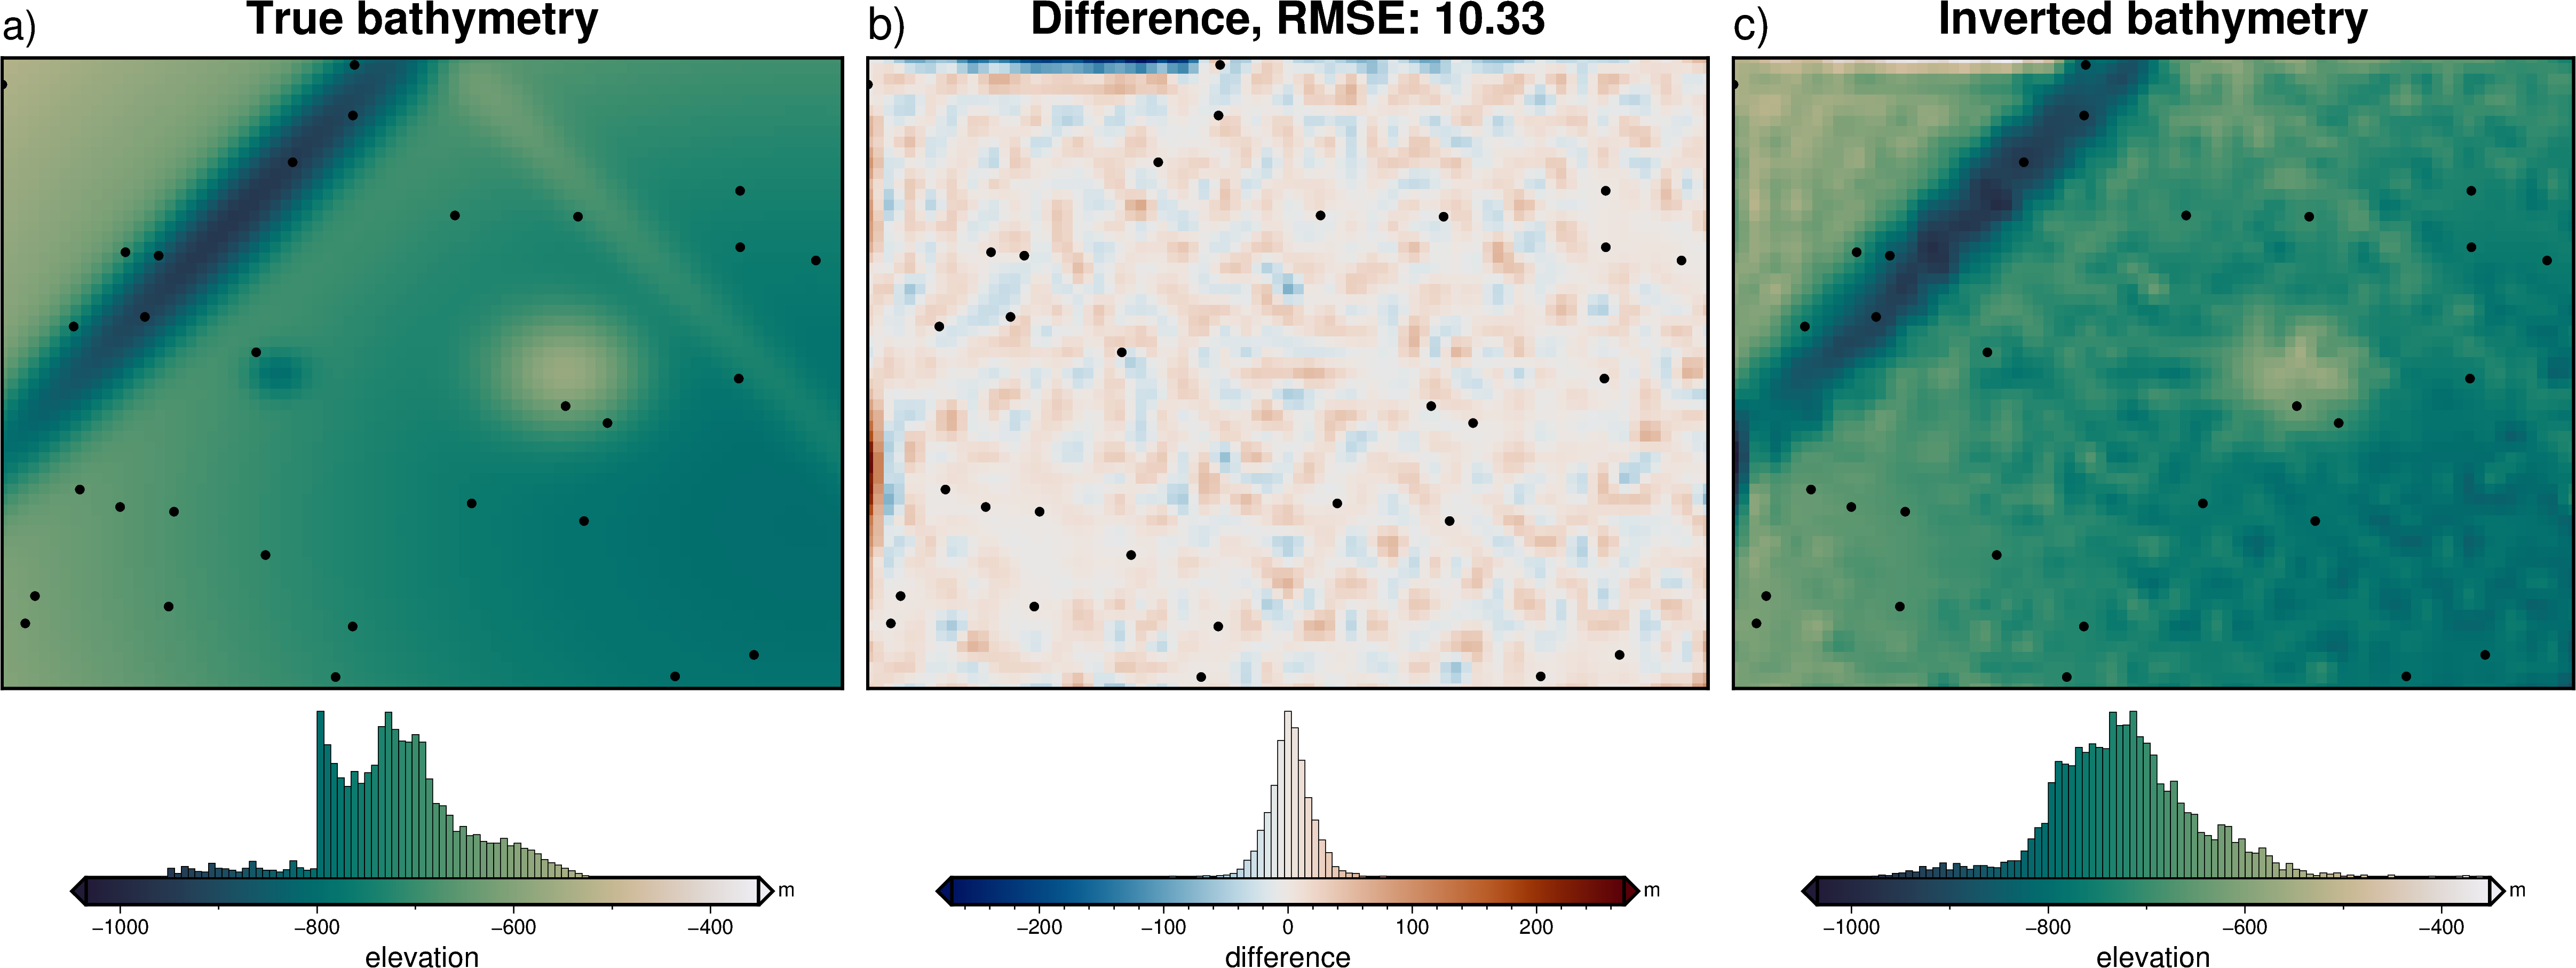

RMSE between surfaces at constraints: 0.43 m


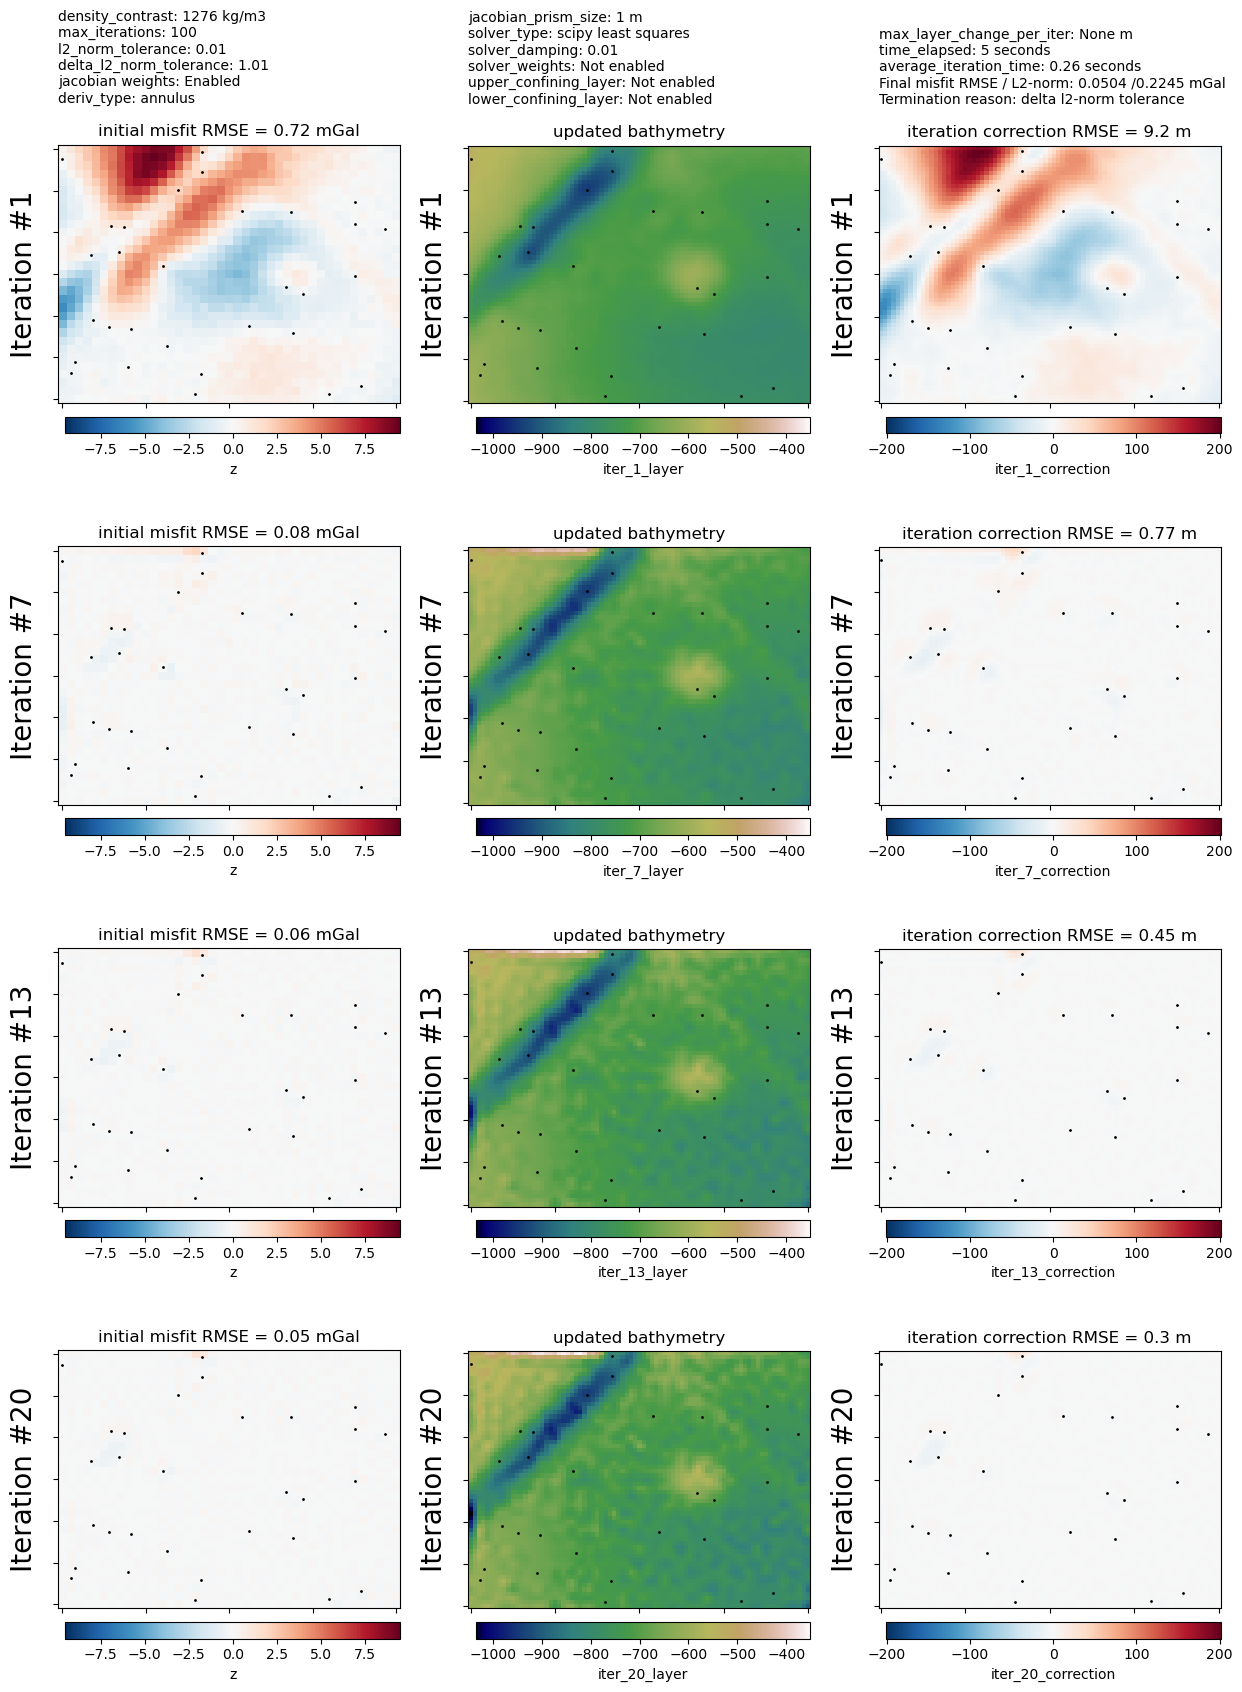

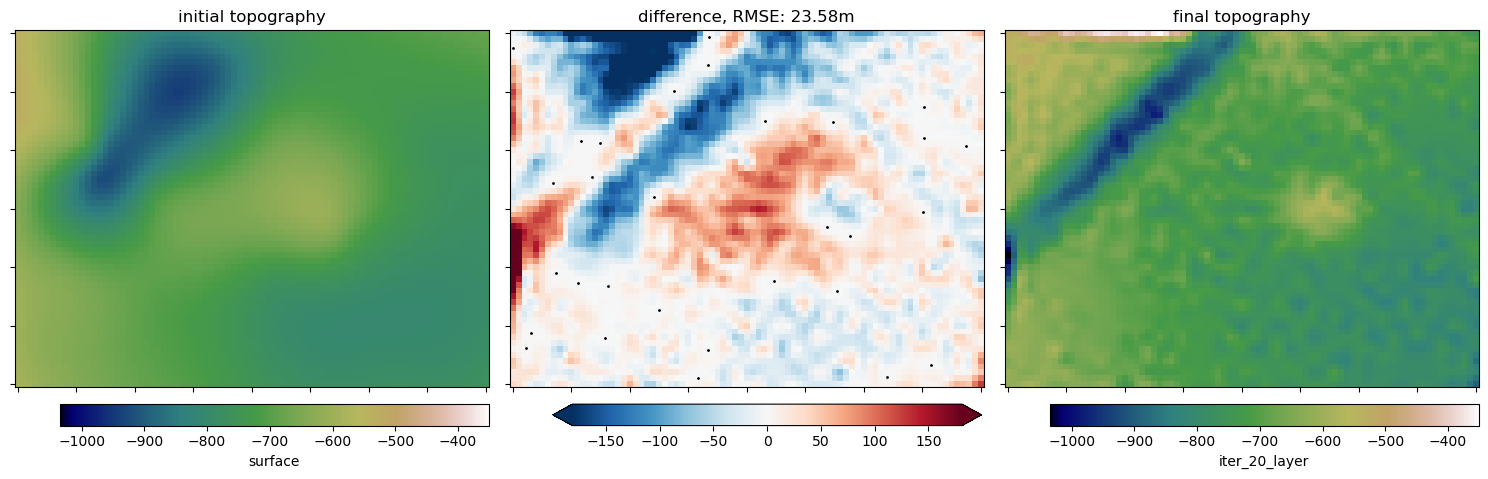

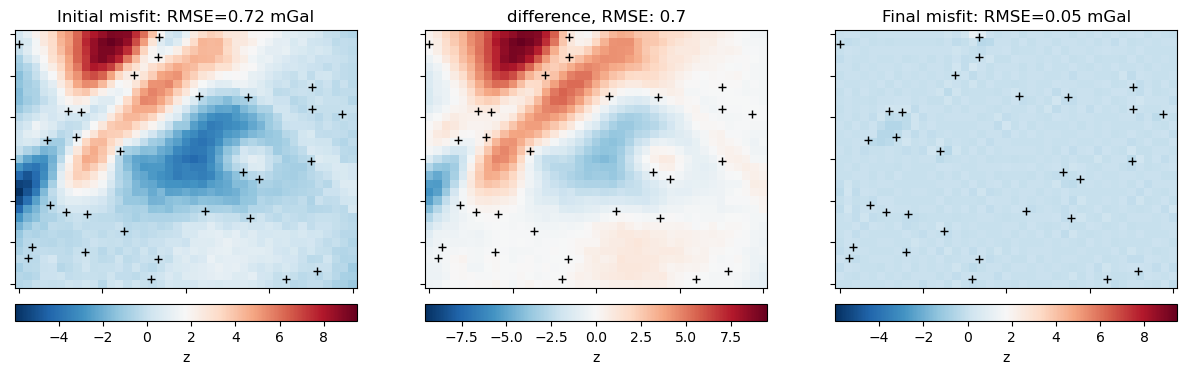

In [66]:
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=sampled_grav_noise[sampled_grav_noise.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Surface 2` and `Surface 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Surface 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Surface 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Surface 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Surface 2` and the low-resolution `Surface 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Surface 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Surface 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

## Calculate regional component for other models 

In [101]:
# regional_kwargs = dict(
#     input_grav=full_res_grav_with_reg,#[full_res_grav_with_reg.test==False],
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     grav_spacing=grav_spacing,
#     inversion_region=inversion_region,
#     true_regional=full_res_grav.set_index(["northing", "easting"]).to_xarray().Surface2,
#     constraints=constraints,
# )

# # set comparison method
# # comparison_method='minimize_constraints'
# comparison_method = "regional_comparison"

# methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"synthetic_simple_region_sep_indiv_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"

#     # remove if exists
#     for p in pathlib.Path(".").glob(f"{fname}*"):
#         pathlib.Path(p).unlink(missing_ok=True)

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     # set number of runs per method
#     n_trials=20

#     # define search space if using GridSampler
#     # search_space = {
#     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
#     #     # "weights_inner": np.arange(1e3, 1900, step=100),
#     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
#     # }
#     # create study
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="BoTorch")
#         study = optuna.create_study(
#             study_name=study_name,
#             storage=storage,
#             direction="minimize",
#             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#             # sampler=optuna.samplers.GridSampler(search_space),
#             load_if_exists=True,
#             )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 500e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#                 parallel=True,
#             )

# # load studies
# study_dfs = []
# for i in methods:
#     study_name = f"synthetic_simple_region_sep_indiv_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     study = optuna.load_study(storage=storage, study_name=study_name)
#     study_df = study.trials_dataframe()
#     study_dfs.append(study_df)

#     # plot results
#     plotting.plot_best_param(
#         study_df, comparison_method, regional_method=i, **regional_kwargs
#     )
#     optuna.visualization.plot_slice(study).show()

# studies = dict(zip(methods, study_dfs))

# for k, v in studies.items():
#     v["params_method"] = k

# regional_sep_combined_studies = pd.concat(
#     studies.values(), ignore_index=True
# ).sort_values(by="value")

In [102]:
# df = regional_sep_combined_studies
# df.head()

In [103]:
# regional_method = df.iloc[0].params_method
# print(f"best method: {regional_method}")

# param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
#     f"params_{regional_method}"
# ]
# print(f"best parameter: {param}")

In [96]:
# true_reg = full_res_grav.set_index(["northing", "easting"]).to_xarray().Surface2

# grids = []
# titles = []
# for i in methods:
#     param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]
#     df_anomalies = regional.regional_seperation(
#         regional_method=i,
#         filter=f"g{param}",
#         trend=int(param),
#         fill_method="pygmt",
#         tension_factor=param,
#         eq_sources=param,
#         depth_type="relative",
#         eq_damping=None,
#         block_size=grav_spacing,
#         **regional_kwargs,
#     )
#     grid = df_anomalies.set_index(["northing", "easting"]).to_xarray().reg
#     rms = utils.RMSE(true_reg - grid)
#     title = f"{i.capitalize()}, RMSE: {round(rms,2)} mGal"
#     grids.append(grid)
#     titles.append(title)

In [97]:
# lims = utils.get_min_max(true_reg)

# fig = maps.plot_grd(
#     true_reg,
#     fig_height=10,
#     # cmap="vik",
#     title="True regional component",
#     region=inversion_region,
#     hist=True,
#     cbar_yoffset=2,
#     cbar_label="mGal",
#     cpt_lims=lims,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# for i, g in enumerate(grids):
#     if i == 0:
#         origin_shift = "both_shift"
#         xshift_amount = -0.5
#         yshift_amount = -1.15
#     elif i == 1:
#         origin_shift = "xshift"
#         xshift_amount = 1
#     elif i == 2:
#         origin_shift = "yshift"
#         yshift_amount = -1.15
#     elif i == 3:
#         origin_shift = "xshift"
#         xshift_amount = -1

#     fig = maps.plot_grd(
#         g,
#         points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         points_style="c0.1c",
#         fig=fig,
#         fig_height=10,
#         # cmap="vik",
#         cpt_lims=lims,
#         title=titles[i],
#         region=inversion_region,
#         hist=True,
#         cbar_label="mGal",
#         cbar_yoffset=2,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )
#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i+1]})",
#         font="20p,Helvetica,black",
#         offset="j0/.3",
#         no_clip=True,
#     )

# fig.show()

In [98]:
# for i in methods:
#     param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]

#     df_anomalies = regional.regional_seperation(
#         regional_method=i,
#         filter=f"g{param}",
#         trend=int(param),
#         fill_method="pygmt",
#         tension_factor=param,
#         eq_sources=param,
#         depth_type="relative",
#         eq_damping=None,
#         block_size=grav_spacing,
#         **regional_kwargs,
#     )

#     _ = utils.grd_compare(
#         regional_kwargs.get("true_regional"),
#         df_anomalies.set_index(["northing", "easting"]).to_xarray().reg,
#         grid1_name="True regional gravity",
#         grid2_name="Calculated regional gravity",
#         title=f"Method: {i}",
#         plot=True,
#         region=inversion_region,
#         plot_type="pygmt",
#         cmap="vik",
#         diff_cmap="vik+h0",
#         hist=True,
#         inset=False,
#         points_style="c.15c",
#         subplot_labels=True,
#         # robust=True,
#         robust=False,
#         verbose="q",
#         cbar_label="mGal",
#     )

method: constraints, parameter: 0.25


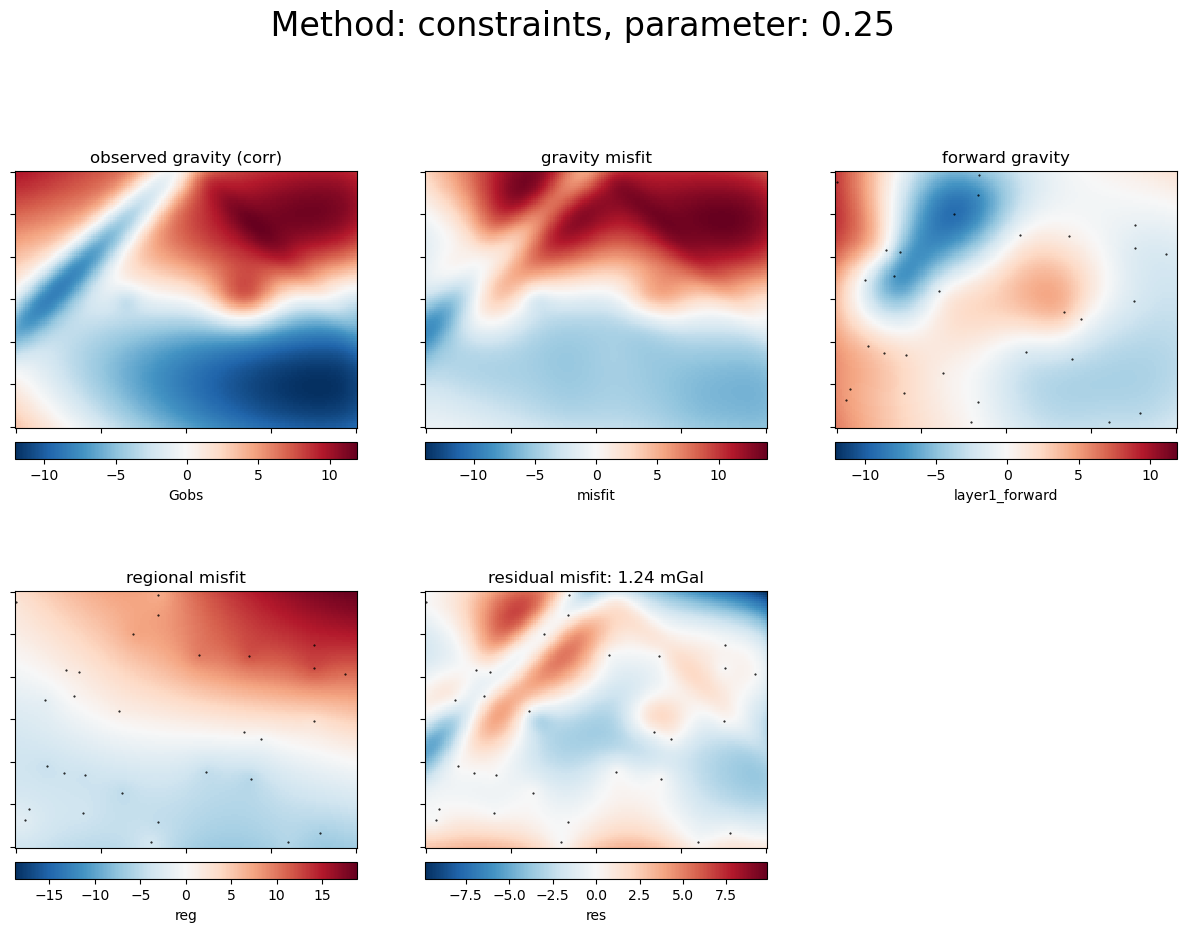

In [109]:
regional_kwargs = dict(
    input_grav=full_res_grav_with_reg,  # [full_res_grav_with_reg.test==False],
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=full_res_grav.set_index(["northing", "easting"]).to_xarray().Surface2,
    constraints=constraints,
)

# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
param = 0.25

# get best param from chosen method.
# param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
#     f"params_{regional_method}"
# ]
print(f"method: {regional_method}, parameter: {param}")

df_anomalies = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=int(param),
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    **regional_kwargs,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    title=f" Method: {regional_method}, parameter: {param}",
    constraints=constraints,  # .rename(columns={"easting":"x","northing":"y"}),
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    # plot_type="pygmt",
    plot_type="xarray",
    robust=False,
)

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

In [ ]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=200,
#     l2_norm_tolerance=0.01,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
#     # apply_weights = True,
#     # weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 10**-1,
# )

# with inv_utils.HiddenPrints():
#     results = inv.inversion_RMSE(

#         input_grav=df_anomalies,
#         # input_grav=df_anomalies_sampled,

#         inversion_region=inversion_region,
#         true_surface = layer1,
#         constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         plot=True,
#         plot_type="xarray",
#         **kwargs,
#     )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,

#         grav_spacing=grav_spacing,
#         # grav_spacing=sampled_grav_spacing,

#         constraints=constraints,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [110]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_inversion_hyperparameters"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=df_anomalies[df_anomalies.test == False],
    testing_data=df_anomalies[df_anomalies.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

[I 2023-04-21 22:40:41,398] A new study created in Journal with name: synthetic_simple_inversion_hyperparameters


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

In [ ]:
study_df.head()

In [ ]:
study.best_params

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=df_anomalies[df_anomalies.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

## repeat with sampled grav and noise

In [ ]:
# contaminate with noise
sampled_grav_with_reg_noise = sampled_grav_with_reg.copy()
sampled_grav_with_reg_noise["Gobs"] = synthetic.contaminate(
    sampled_grav_with_reg_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
sampled_grav_with_reg_noise = inv.misfit(
    input_grav=sampled_grav_with_reg_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)

In [ ]:
# regional_kwargs = dict(
#     input_grav=sampled_grav_with_reg,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     grav_spacing=sampled_grav_spacing,
#     inversion_region=inversion_region,
#     true_regional=full_res_grav.set_index(["northing", "easting"]).to_xarray().Surface2,
#     constraints=constraints,
# )

# # set comparison method
# # comparison_method='minimize_constraints'
# comparison_method = "regional_comparison"

# methods = ["filter", "trend", "constraints", "eq_sources"]

# # for i in methods:
# #     # set name and storage for the optimization
# #     study_name = f"synthetic_simple_sampled_region_sep_indiv_{i}_{comparison_method}"
# #     fname = f"../optimization_logs/{study_name}.log"

# #    # remove if exists
# #    # for p in pathlib.Path(".").glob(f"{fname}*"):
# #    #     pathlib.Path(p).unlink(missing_ok=True)

# #     with warnings.catch_warnings():
# #         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
# #         storage = JournalStorage(JournalFileStorage(fname))

# #     # set number of runs per method
# #     n_trials=20

# #     # define search space if using GridSampler
# #     # search_space = {
# #     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
# #     #     # "weights_inner": np.arange(1e3, 1900, step=100),
# #     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
# #     # }
# #     # create study
# #     with warnings.catch_warnings():
# #         warnings.filterwarnings("ignore", message="BoTorch")
# #         study = optuna.create_study(
# #             study_name=study_name,
# #             storage=storage,
# #             direction="minimize",
# #             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
# #             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
# #             # sampler=optuna.samplers.GridSampler(search_space),
# #             load_if_exists=True,
# #             )

# #     # define the objective function
# #     objective = optimization.optimal_regional_params(
# #         comparison_method = comparison_method,
# #         regional_method = i,
# #         filter_limits = [10e3, 500e3, 10e3], # 100 options
# #         trend_limits = [1, 20, 1], # 20 options
# #         constraints_limits = [0, 1, 0.01], # 101 options
# #         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
# #         **regional_kwargs)

# #     # run the optimization
# #     with inv_utils.HiddenPrints():
# #         with warnings.catch_warnings():
# #             warnings.simplefilter("ignore")
# #             study, study_df = optimization.optuna_parallel(
# #                 study_name=study_name,
# #                 study_storage=storage,
# #                 objective=objective,
# #                 n_trials=n_trials,
# #                 maximize_cpus=True,
# #                 parallel=True,
# #             )

# # load studies
# study_dfs = []
# for i in methods:
#     study_name = f"synthetic_simple_sampled_region_sep_indiv_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     study = optuna.load_study(storage=storage, study_name=study_name)
#     study_df = study.trials_dataframe()
#     study_dfs.append(study_df)

#     # plot results
#     # plotting.plot_best_param(
#     #     study_df, comparison_method, regional_method=i, **regional_kwargs
#     # )
#     # optuna.visualization.plot_slice(study).show()

# studies = dict(zip(methods, study_dfs))

# for k, v in studies.items():
#     v["params_method"] = k

# regional_sep_combined_studies = pd.concat(
#     studies.values(), ignore_index=True
# ).sort_values(by="value")

In [ ]:
# df = regional_sep_combined_studies
# df.head()

In [ ]:
# regional_method = df.iloc[0].params_method
# print(f"best method: {regional_method}")

# param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
#     f"params_{regional_method}"
# ]
# print(f"best parameter: {param}")

In [ ]:
regional_kwargs = dict(
    input_grav=sampled_grav_with_reg_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=sampled_grav_with_reg_noise.set_index(["northing", "easting"])
    .to_xarray()
    .Surface2,
    constraints=constraints,
)

# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
param = 0.25

# get best param from chosen method.
# param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
#     f"params_{regional_method}"
# ]
print(f"method: {regional_method}, parameter: {param}")

df_anomalies = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=int(param),
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    **regional_kwargs,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    title=f" Method: {regional_method}, parameter: {param}",
    constraints=constraints,  # .rename(columns={"easting":"x","northing":"y"}),
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    # plot_type="pygmt",
    plot_type="xarray",
    robust=False,
)

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_noise_regional_inversion_hyperparameters"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
for p in pathlib.Path(".").glob(f"{fname}*"):
    pathlib.Path(p).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    "weights_outer": np.arange(
        layer_spacing * 2, layer_spacing * 10, step=layer_spacing, dtype="float"
    ),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="minimize",
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.CV_inversion_damping_and_weights(
    training_data=df_anomalies[df_anomalies.test == False],
    testing_data=df_anomalies[df_anomalies.test == True],
    weights_outer_limits=[layer_spacing * 2, layer_spacing * 10],
    weights_step=layer_spacing,
    damping_limits=[-6, 1],  # damping = 10^damping_limit
    starting_prisms=starting_prisms,
    constraints=constraints,
    layer_spacing=layer_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

# run the optimization
# with inv_utils.HiddenPrints():
study, study_df = optimization.optuna_parallel(
    study_name=study_name,
    study_storage=storage,
    objective=objective_func,
    n_trials=n_trials,
    maximize_cpus=True,
    parallel=True,
)

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=["rmse"],
    # include_duration=True,
)

In [ ]:
study_df.head()

In [ ]:
study.best_params

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=study.best_params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)

starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    input_grav=df_anomalies[df_anomalies.test == False],
    true_surface=layer1,
    prism_layer=starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    inversion_region=inversion_region,
    **kwargs,
)

## Plot inversion inputs

In [ ]:
# residual = df_anomalies.set_index(["northing", "easting"]).to_xarray().res
# # residual.plot(robust=True)

# # plot residual misfit
# fig = maps.plot_grd(
#     grid=residual,
#     fig_height=8,
#     cmap="vik+h0",
#     region=buffer_region,
#     title="Residual Misfit",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 2
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Surface 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()